In [1]:
import numpy as np
import pandas as pd
import os
import socket
import platform
from pathlib import Path
import time
import glob
import re
import gc
import shutil

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from dask.distributed import Client
from dask.distributed import as_completed
from IPython.display import IFrame
from ClusterWrap.clusters import janelia_lsf_cluster

from tqdm.notebook import tqdm

from skimage.transform import ProjectiveTransform, AffineTransform, EuclideanTransform, warp
from sklearn.linear_model import (LinearRegression,
                                  TheilSenRegressor,
                                  RANSACRegressor,
                                  HuberRegressor,
                                  RidgeCV,
                                  LassoCV)
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

import mrcfile
try:
    import skimage.external.tifffile as tiff
except:
    import tifffile as tiff

from FIBSEM_gs_py.FIBSEM_gs import FIBSEM_frame, FIBSEM_dataset

from FIBSEM_gs_py.FIBSEM_gs import (get_min_max_thresholds,
                          get_spread,
                          check_DASK,
                          calculate_gradent_map,
                          radial_profile_select_angles,
                          add_scale_bar,
                          Single_Image_Noise_Statistics,
                          Single_Image_SNR,
                          clip_pad_image,
                          build_kernel_FFT_zero_destreaker_XY,
                          build_kernel_FFT_zero_destreaker_radii_angles,
                          build_kernel_FFT_destreaker_autodetect,
                          merge_images_with_transition,
                          destreak_mrc_stack_with_kernel,
                          destreak_single_frame_kernel_shared,
                          smooth_mrc_stack_with_kernel,
                          analyze_mrc_stack_registration,
                          analyze_registration_frames,
                          bin_crop_mrc_stack,
                          mrc_stack_estimate_resolution_blobs_2D,
                          mrc_stack_plot_2D_blob_examples,
                          merge_tiff_files_mrc_stack,
                          show_eval_box_mrc_stack,
                          ShiftTransform,
                          XScaleShiftTransform,
                          ScaleShiftTransform,
                          RegularizedAffineTransform,
                          read_kwargs_xlsx,
                          generate_report_mill_rate_xlsx,
                          generate_report_FOV_center_shift_xlsx,
                          generate_report_data_minmax_xlsx,
                          generate_report_ScanRate_EHT_xlsx,
                          generate_report_transf_matrix_from_xlsx,
                          generate_report_from_xls_registration_summary,
                          plot_registrtion_quality_xlsx,
                          plot_cross_sections_mrc_stack,
                          plot_2D_blob_results,
                          plot_2D_blob_examples)

from skimage import __version__ as skimage_version
print('skimage version: ', skimage_version)
from scipy import __version__ as scipy_version
print('scipy version:   ', scipy_version)
from sklearn import __version__ as sklearn_version
print('sklearn version: ', sklearn_version)
from cv2 import __version__ as cv2_version
print('Open CV version: ', cv2_version)
from FIBSEM_gs_py import __version__ as FIBSEM_gs_py_version
print('FIBSEM_gs_py version: ', FIBSEM_gs_py_version)

skimage version:  0.24.0
scipy version:    1.13.1
sklearn version:  1.6.1
Open CV version:  4.10.0
FIBSEM_gs_py version:  4.1.4


# Set up Local DASK Client and Monitor Window

In [ ]:
#start / restart client
try:
    client.restart()
except:
    client = Client()
    
# setup a window to monitor the client progress
use_DASK, status_update_address = check_DASK(client)
IFrame(src=status_update_address, width='100%', height='900px')

# This is where the data processing begins.

# Step 0a: Set up the Processing Parameters.

In [2]:
data_dir = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw'

ftype = 1 # 0 for Shan's .dat files, 1 for tif files

use_DASK = True
DASK_client_retries = 3  # Number of allowed automatic retries if a task fails

thr_min = 1e-3    # This are used to determine Min and Max data boundaries for I8 conversion
thr_max = 1e-3                            
sliding_minmax = True   # If True, Global Min and Max for I8 conversion the entire data set is used. If False, Min and Max are allowed to vary slowly.
nbins = 256             # Number of histogram bins for determining Min and Max above

BFMatcher = False       # If True, the BF Matcher is used for keypont matching
                        # otherwise FLANN Matcher (faster, preferable) is used.

save_matches = True     # If True, matches will be saved into individual files

# Uncomment one from the below choices:
#TransformType = ShiftTransform                #  only x-shift and y-shift
#TransformType = XScaleShiftTransform          #  x-scale, x-shift, y-shift
#TransformType = ScaleShiftTransform           #  x-scale, y-scale, x-shift, y-shift
#TransformType = AffineTransform               #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
TransformType = RegularizedAffineTransform     #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
                                                # with regularization on deviation from ShiftTransform
if TransformType == RegularizedAffineTransform:
    l2_param = 1e-5                                  # regularization strength (shrinkage parameter)
    l2_matrix = np.eye(6)*l2_param                   # initially set equal shrinkage on all coefficients
    l2_matrix[2,2]=0                                 # turn OFF the regularization on shifts
    l2_matrix[5,5]=0                                 # turn OFF the regularization on shifts
    targ_vector = np.array([1, 0, 0, 0, 1, 0])       # target transformation is shift only: Sxx=Syy=1, Sxy=Syx=0
    suffix = 'l2_{:.0e}'.format(l2_matrix[0,0])
else:
    l2_matrix= None
    targ_vector = None
    suffix = 'bilin'                  # optonal characters that will be added to the end of the filename (before the extension)

SIFT_nfeatures = 0     # SIFT libary default is 0. The number of best features to retain.
                                # The features are ranked by their scores (measured in SIFT algorithm as the local contrast)
    
SIFT_nOctaveLayers = 3          # SIFT libary default  is 3. The number of layers in each octave.
                                # 3 is the value used in D. Lowe paper. The number of octaves is computed automatically from the image resolution.

SIFT_contrastThreshold = 0.025   # SIFT libary default  is 0.04. The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions.
                                # The larger the threshold, the less features are produced by the detector.
                                # The contrast threshold will be divided by nOctaveLayers when the filtering is applied.
                                # When nOctaveLayers is set to default and if you want to use the value used in
                                # D. Lowe paper (0.03), set this argument to 0.09.
                                
SIFT_edgeThreshold = 10         # SIFT libary default  is 10. The threshold used to filter out edge-like features.
                                # Note that the its meaning is different from the contrastThreshold,
                                # i.e. the larger the edgeThreshold, the less features are filtered out
                                # (more features are retained).

SIFT_sigma = 5.0                # SIFT library default is 1.6. 	The sigma of the Gaussian applied to the input image at the octave #0.
                                # If your image is captured with a weak camera with soft lenses, you might want to reduce the number.
    
Lowe_Ratio_Threshold = 0.7
    
solver = 'RANSAC'       # String indicating which solver is to be used.'RANSAC' will use RANSAC (Random Sample Consensus) algorithm.
                        # 'LinReg' will use Linear Regression with iterative "Throwing out the Worst Residual" Heuristic
RANSAC_initial_fraction = 0.01  # fraction of data points for initial RANSAC iteration step.

drmax = 1.5              # dimensions - pixels.
                         #  - in the case of 'RANSAC' - Maximum distance for a data point to be classified as an inlier.
                         #  - in the case of 'LinReg' - outlier threshold for iterative regression:
                         # For each matched pair of keypoins the error is calculated as err[j] = dst_pts[j] - A*src_pts[j]
                         # The iterative procedure throws away the matched keypoint pair with worst error on every iteration
                         # until the worst error falls below drmax or the max number of iterations is reached.

max_iter = 1000     # max number of iterations in the iterative procedure above

save_data_as_tiff = False    # Convert and Save the InLens.tif data

save_res_png = True        # Save PNG images of the intemediate processing statistics and final registration quality check.

dtp = np.int16                  # Python data type for saving. Deafult is int16, the other option currently is uint8.

preserve_scales = True       # If True, the transformation matrix will be adjusted using the settings defined by fit_params below
fit_params = ['SG', 501, 3]  # perform the above adjustment using  Savitzky-Golay (SG) filter with parameters
                             # window size 701, polynomial order 3
#fit_params = ['LF']         # another option is to use linear fit with forces start points Sxx and Syy = 1 and Sxy and Syx = 0
#fit_params = ['PF', 2]      # another option is to use polynomial fit (in this case of order 2)

subtract_linear_fit = [True, True]  # If True, the linear slopes along X- and Y- directions (respectively) will be subtracted from the cumulative shifts.
                                    # This is performed after the optimal frame-to-frame shifts are recalculated for preserve_scales = True 
subtract_FOVtrend_from_fit = [True, True]  # If True, FOV trends (image shifts performed during imaging) will be subtracted first, so they do not bias the linear trends.
    
pad_edges = True             # If True, the edges will be padded with the amount equal to max shift excursion in each direction

flipY = True                 # If True, the dataset will be flipped along Y-direction

zbin_factor =  1             # binning factor in z-direction (milling direction). Data will be binned when saving the final result. Default is 1.

eval_metrics = ['NSAD', 'NCC', 'NMI', 'FSC']   # list of metrics used for evaluation of registration (and resolution).
                                        # Options are; 'NSAD', 'NCC', 'NMI', 'FSC'
fnm_types = ['h5', 'mrc']    #   File type(s) for output data. Options are: ['h5', 'mrc'].
                             # Defauls is ['mrc']. 
                             # 'h5' is BigDataViewer HDF5 format, uses npy2bdv package. Use empty list if do not want to save the data.

int_order = 1                #     The order of interpolation. The order has to be in the range 0-5:
                             #    - 0: Nearest-neighbor
                             #    - 1: Bi-linear (default)
                             #    - 2: Bi-quadratic
                             #    - 3: Bi-cubic
                             #    - 4: Bi-quartic
                             #    - 5: Bi-quintic
#suffix = suffix + '_r2'
#********************************************************************************************************
# DO NOT MODIFY THE CODE BELOW!
#********************************************************************************************************

if ftype == 0:
    fls = sorted(glob.glob(os.path.join(data_dir,'*.dat')))
    if len(fls) == 0 :
        fls = sorted(glob.glob(os.path.join(data_dir,'*/*.dat')))
if ftype == 1:
    fls = sorted(glob.glob(os.path.join(data_dir,'slice*.tif')))
    if len(fls) == 0 :
        fls = sorted(glob.glob(os.path.join(data_dir,'*/slice*.tif')))
        
nfrs = len(fls)

if fit_params[1] > nfrs//4*2-1:  # if smoothing aperture (Sov-Gol) is larger than number of frames, reduce the aperture
    fit_params[1] = nfrs//4*2-1

fnm0 = (os.path.join(data_dir,fls[0]))
frame0 = FIBSEM_frame(fnm0, ftype=ftype)
Sample_ID = frame0.Sample_ID.strip('\x00')
EightBit = frame0.EightBit
Sample_ID = 'AMST dataset'

SIFT_kwargs = {
    'ftype' : ftype,
    'data_dir' : data_dir,
    'Sample_ID' : Sample_ID,
    'EightBit' : EightBit,
    'use_DASK' : use_DASK,
    'DASK_client_retries' : DASK_client_retries,
    'thr_min' : thr_min, 
    'thr_max' : thr_max,
    'sliding_minmax' : sliding_minmax,
    'nbins' : nbins,
    'TransformType' : TransformType,
    'SIFT_nfeatures' : SIFT_nfeatures,
    'SIFT_nOctaveLayers' : SIFT_nOctaveLayers,
    'SIFT_contrastThreshold' : SIFT_contrastThreshold,
    'SIFT_edgeThreshold' : SIFT_edgeThreshold,
    'SIFT_sigma' : SIFT_sigma,
    'Lowe_Ratio_Threshold' : Lowe_Ratio_Threshold,
    'l2_matrix' : l2_matrix,
    'targ_vector': targ_vector, 
    'solver' : solver,
    'RANSAC_initial_fraction' : RANSAC_initial_fraction,
    'drmax' : drmax,
    'max_iter' : max_iter,
    'BFMatcher' : BFMatcher,
    'save_matches' : save_matches,
    'save_res_png' : save_res_png,
    'save_data_as_tiff' : save_data_as_tiff,
    'dtp' : dtp,
    'preserve_scales' : preserve_scales,
    'fit_params' : fit_params,
    'subtract_linear_fit' : subtract_linear_fit,
    'subtract_FOVtrend_from_fit' : subtract_FOVtrend_from_fit,
    'pad_edges' : pad_edges,
    'zbin_factor' : zbin_factor,
    'eval_metrics' : eval_metrics,
    'fnm_types' : fnm_types,
    'flipY' : flipY,
    'int_order' : int_order,
    'suffix' : suffix}

test_dataset = FIBSEM_dataset(fls, fnm_reg = 'Registered_RegAffine.mrc', **SIFT_kwargs)

2025/09/05  10:07:38   Registered data will be saved into:  Registered_RegAffine.mrc
Total Number of frames:  1727


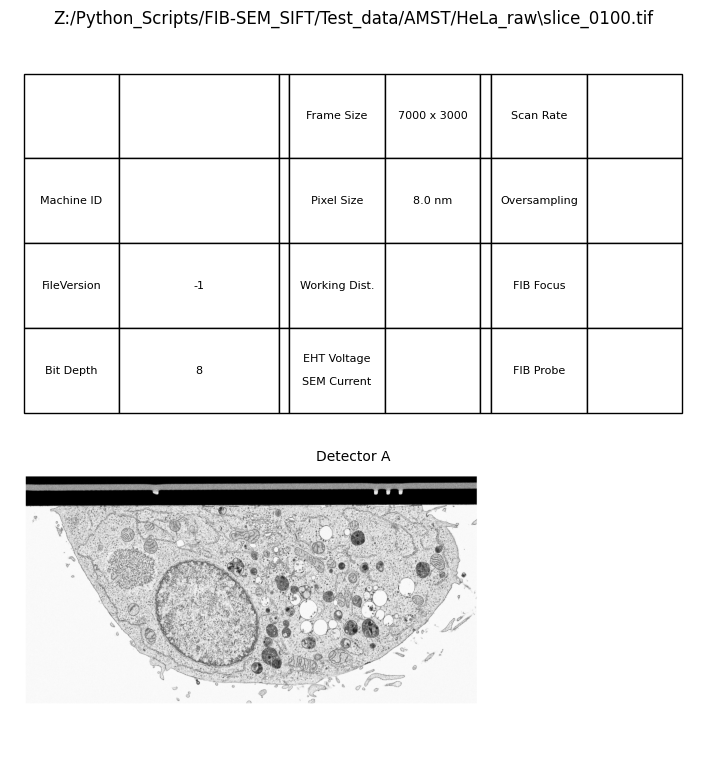

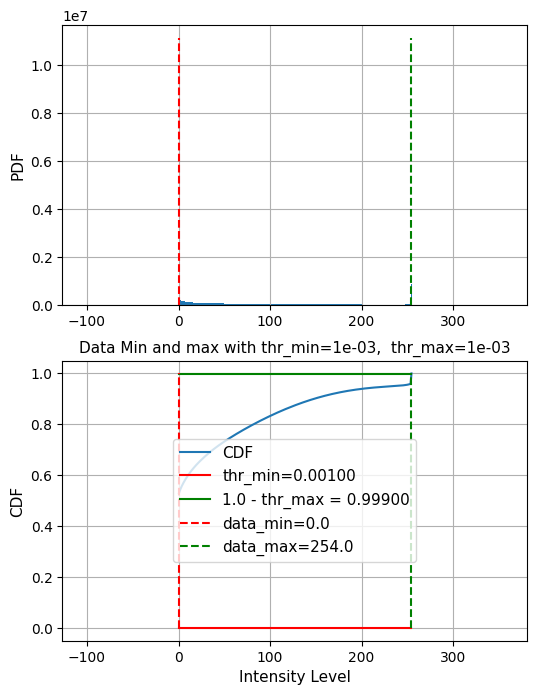

In [3]:
fr_inds = [100]
for fr_ind in fr_inds:
    test_frame = FIBSEM_frame(fls[fr_ind])
    test_frame_suff = Path(fls[fr_ind]).suffix
    snapshot_name = os.path.join(data_dir, os.path.split(fls[fr_ind])[1].replace(test_frame_suff, '_snapshot.png'))
    test_frame.save_snapshot(snapshot_name=snapshot_name)
    get_min_max_thresholds(test_frame.RawImageA, disp_res=True)

In [4]:
test_frame.header

{'NewSubfileType': <FILETYPE.UNDEFINED: 0>,
 'ImageWidth': 7000,
 'ImageLength': 3000,
 'BitsPerSample': 8,
 'PhotometricInterpretation': <PHOTOMETRIC.MINISBLACK: 1>,
 'ImageDescription': 'ImageJ=1.52d',
 'StripOffsets': (148,),
 'SamplesPerPixel': 1,
 'RowsPerStrip': 3000,
 'StripByteCounts': (21000000,)}

# Step 0b: Check the settings: Perform SIFT alignemebts ontwo frames in the middle of the stack

2025/09/05  10:07:44   DASK client does not exist. Will perform local computations
Sample ID:    AMST dataset
File:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\slice_0863.tif , extracted 27600 keypoints
File:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\slice_0864.tif , extracted 27325 keypoints


Repeating SIFT calculation 1 times:   0%|          | 0/1 [00:00<?, ?it/s]


# of detected matches: 1508

thr_min=1e-03, thr_max=1e-03
RegularizedAffineTransform, RANSAC,  FLANN
SIFT_nfeatures=0
SIFT_nOctaveLayers=3,  SIFT_edgeThreshold=10.000
SIFT_contrastThreshold=0.025,  SIFT_sigma=5.000
RANSAC_initial_fraction = 0.0100, max_iter=1000
drmax=1.500
# of keypoints = 27600, # of matches =1508
2025/09/05  10:08:23   Transformation Matrix determined using RegularizedAffineTransform using RANSAC solver
[[ 9.99902192e-01  4.18396207e-04 -2.80439676e-01]
 [ 1.54563715e-05  1.00026160e+00 -3.90359170e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
1508 keypoint matches were detected with 1.5 pixel outlier threshold
Number of iterations: 1514
CPU times: total: 1min 28s
Wall time: 39.1 s


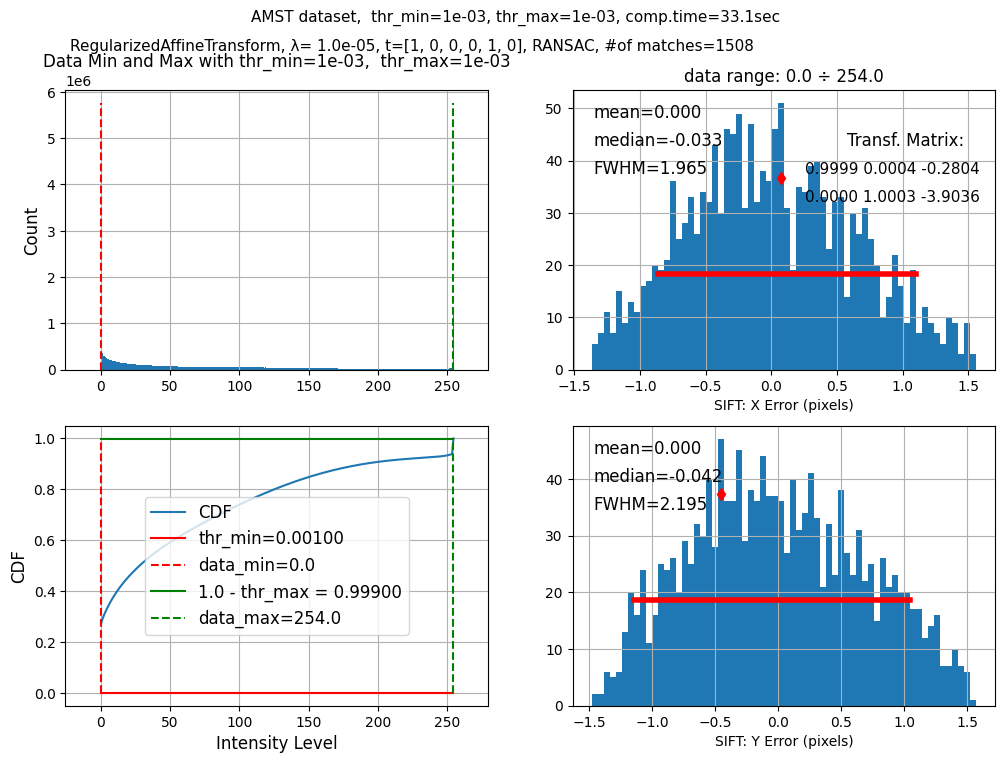

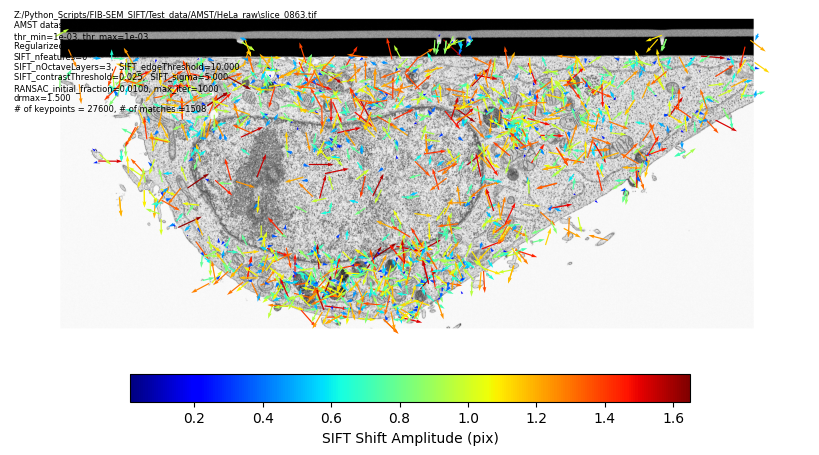

In [5]:
%%time
SIFT_evaluation_results = test_dataset.SIFT_evaluation()

2025/09/05  10:08:26   DASK client does not exist. Will perform local computations
Sample ID:    AMST dataset
File:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\slice_0030.tif , extracted 16997 keypoints
File:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\slice_0031.tif , extracted 17115 keypoints


Repeating SIFT calculation 1 times:   0%|          | 0/1 [00:00<?, ?it/s]


# of detected matches: 1227

thr_min=1e-03, thr_max=1e-03
RegularizedAffineTransform, RANSAC,  FLANN
SIFT_nfeatures=0
SIFT_nOctaveLayers=3,  SIFT_edgeThreshold=10.000
SIFT_contrastThreshold=0.025,  SIFT_sigma=5.000
RANSAC_initial_fraction = 0.0100, max_iter=1000
drmax=1.500
# of keypoints = 16997, # of matches =1227
2025/09/05  10:09:03   Transformation Matrix determined using RegularizedAffineTransform using RANSAC solver
[[ 1.00001606e+00 -2.53845083e-05 -3.96828506e-01]
 [-9.20266833e-05  9.99969134e-01  1.20827451e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
1227 keypoint matches were detected with 1.5 pixel outlier threshold
Number of iterations: 1230
CPU times: total: 1min 8s
Wall time: 37.1 s


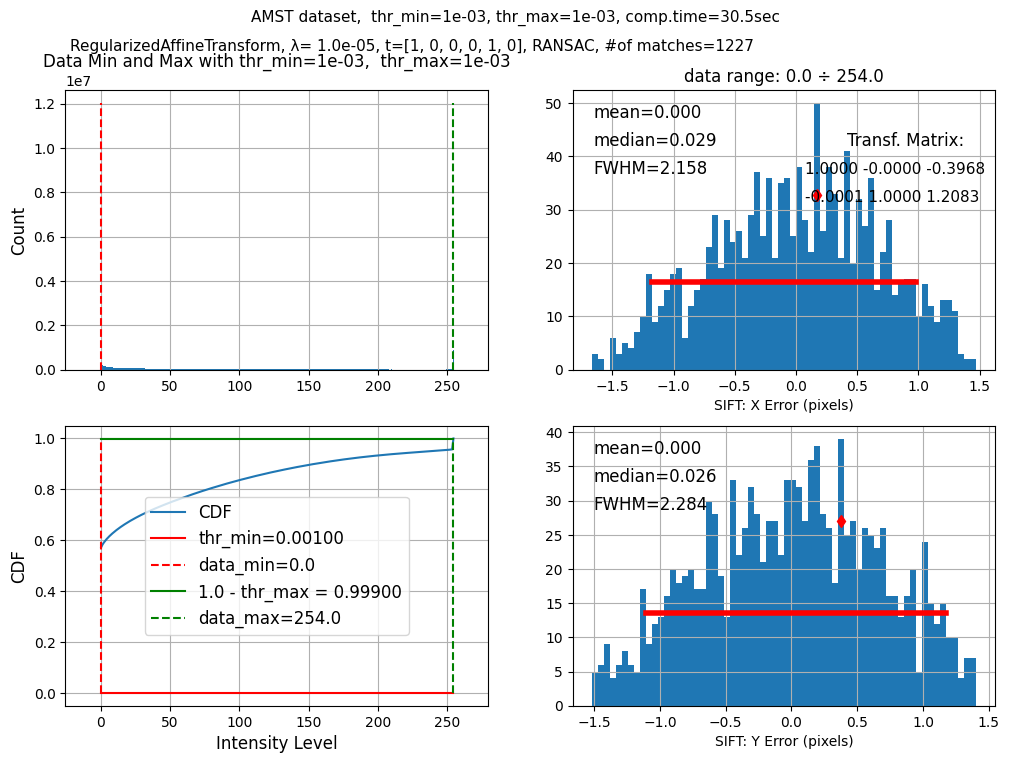

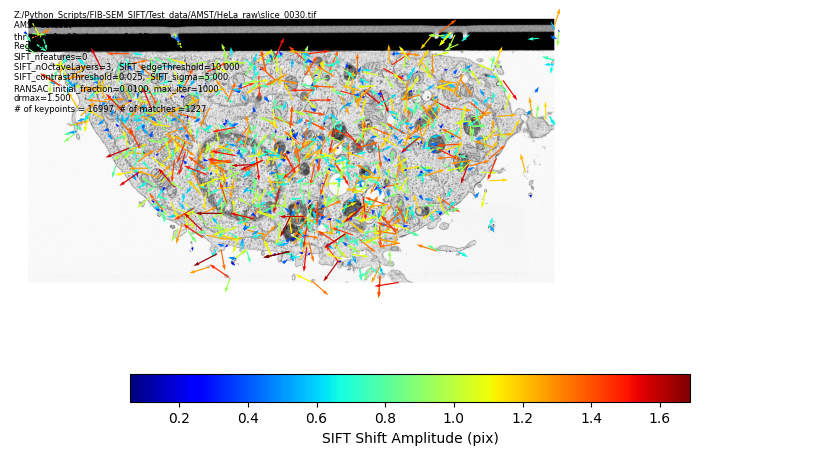

In [6]:
%%time
SIFT_evaluation_results = test_dataset.SIFT_evaluation(eval_fls=[fls[30], fls[31]])

2025/09/05  10:09:06   DASK client does not exist. Will perform local computations
Sample ID:    AMST dataset
File:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\slice_0030.tif , extracted 16997 keypoints
File:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\slice_0031.tif , extracted 17115 keypoints


Repeating SIFT calculation 1 times:   0%|          | 0/1 [00:00<?, ?it/s]


# of detected matches: 1450

thr_min=1e-03, thr_max=1e-03
RegularizedAffineTransform, LinReg,  FLANN
SIFT_nfeatures=0
SIFT_nOctaveLayers=3,  SIFT_edgeThreshold=10.000
SIFT_contrastThreshold=0.025,  SIFT_sigma=5.000
RANSAC_initial_fraction = 0.0100, max_iter=1000
drmax=1.500
# of keypoints = 16997, # of matches =1450
2025/09/05  10:09:44   Transformation Matrix determined using RegularizedAffineTransform using LinReg solver
[[ 1.00000902e+00  7.70238350e-05 -4.56450029e-01]
 [-7.37962102e-05  1.00007844e+00  1.10751923e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
1450 keypoint matches were detected with 1.5 pixel outlier threshold
Number of iterations: 1001
CPU times: total: 1min 9s
Wall time: 37.7 s


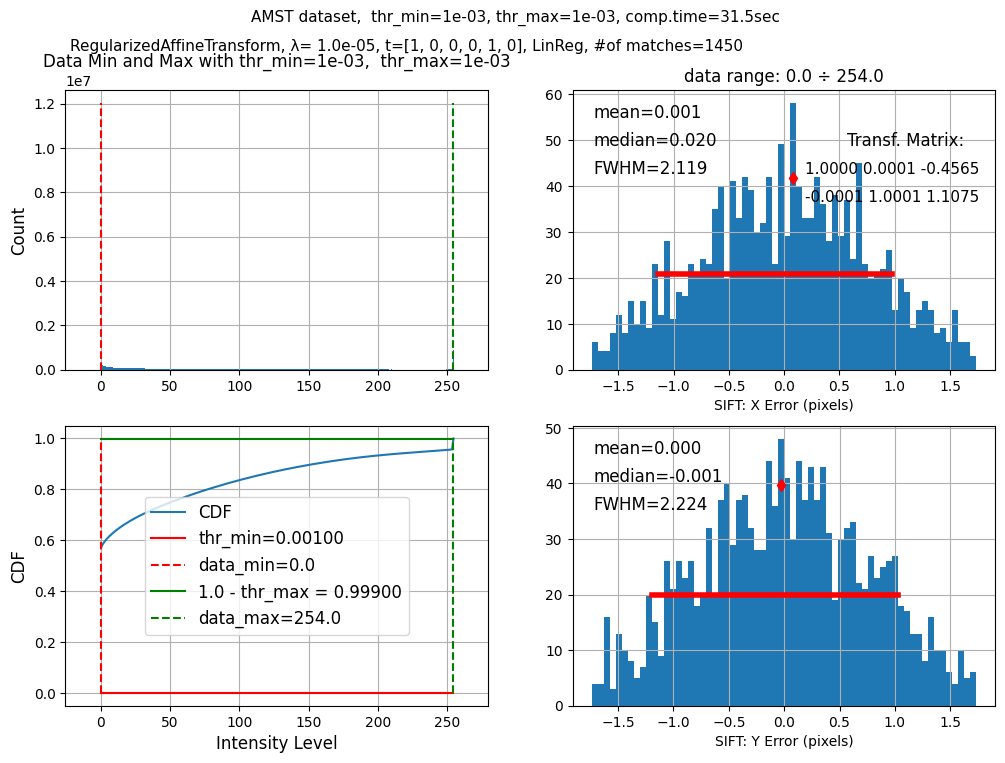

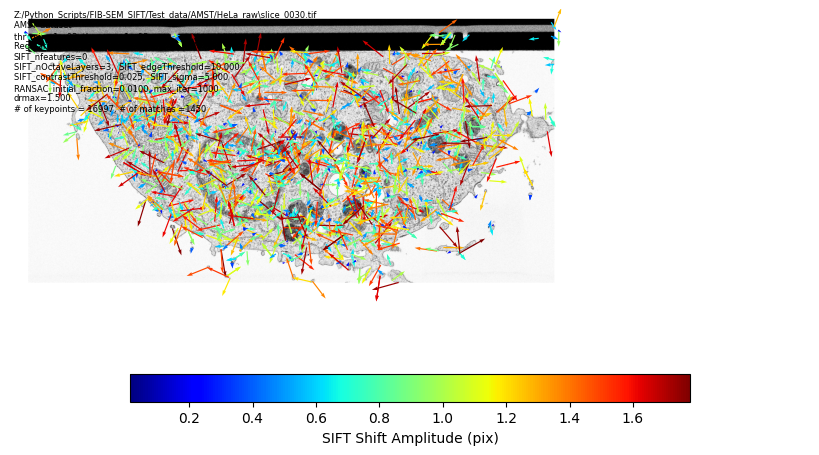

In [7]:
%%time
SIFT_evaluation_results = test_dataset.SIFT_evaluation(eval_fls=[fls[30], fls[31]],
                                                       solver='LinReg')

# Now Perform SIFT Computations using DASK Distributed (local cluster, using SCATTER, MAP and GATHER)

# Step 2a: Save InLens.tif Data (Optional)

In [8]:
if save_data_as_tiff:
    test_dataset.convert_raw_data_to_tif_files(client)

# Step 2b: Evaluate parameters of FIBSEM data set (Data Min/Max, Working Distance, Milling Y Voltage, FOV center positions)

2025/09/05  10:09:49  DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:8787/status to monitor DASK progress
Evaluating the parameters of FIBSEM data set (data Min/Max, Working Distance, Milling Y Voltage, FOV center positions, Scan Rate, EHT)
Original data is 8-bit, no need to find Min and Max for 8-bit conversion
2025/09/05  10:09:50   Saving the FIBSEM dataset statistics (Min/Max, Mill Rate, FOV Shifts into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\FIBSEM_Data.xlsx
No milling rate data is available, isotropic voxel size is set to 8.00 nm
Using fit_params:  SG 431 3


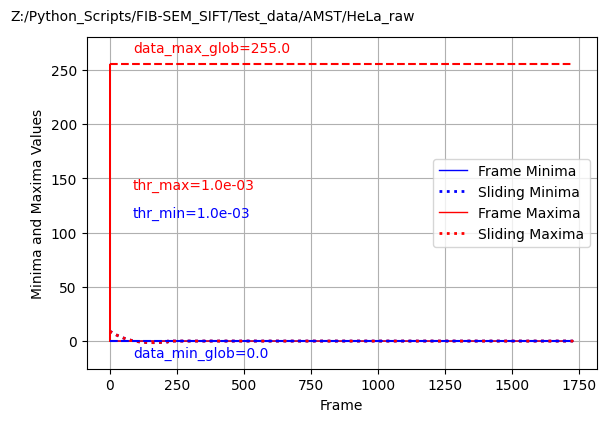

In [9]:
with Client() as client:
    FIBSEM_Data = test_dataset.evaluate_FIBSEM_statistics(DASK_client = client)
generate_report_data_minmax_xlsx(FIBSEM_Data[0])

# Steps 3 and 4: Extract Key Points and Descriptors, Find Matches and Transformations

Step 3: Extract Key Points and Descriptors
2025/09/05  10:09:55  DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:8787/status to monitor DASK progress
2025/09/05  10:09:55   Using DASK distributed
Step 3: Elapsed time: 5092.10 seconds

Step 4: Select Good Matches with FLANN matcher
Step 4: using RegularizedAffineTransform Transformation Model with RANSAC solver
Step 4: RegularizedAffineTransform parameters:
Step 4: Regularization matrix: 
[[1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
Step 4: Target Solution:  [1 0 0 0 1 0]
2025/09/05  11:34:47  DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:8787/status to monitor DASK progress
2025/09/05  11:34:47   Using DASK distributed
Mean Number of Keypoin

Calculating Cummilative Transformation Matrix:   0%|          | 0/1726 [00:00<?, ?it/s]

Recalculating the shifts for preserved scales:   0%|          | 0/1726 [00:00<?, ?it/s]

CPU times: total: 5min 57s
Wall time: 1h 35min 17s


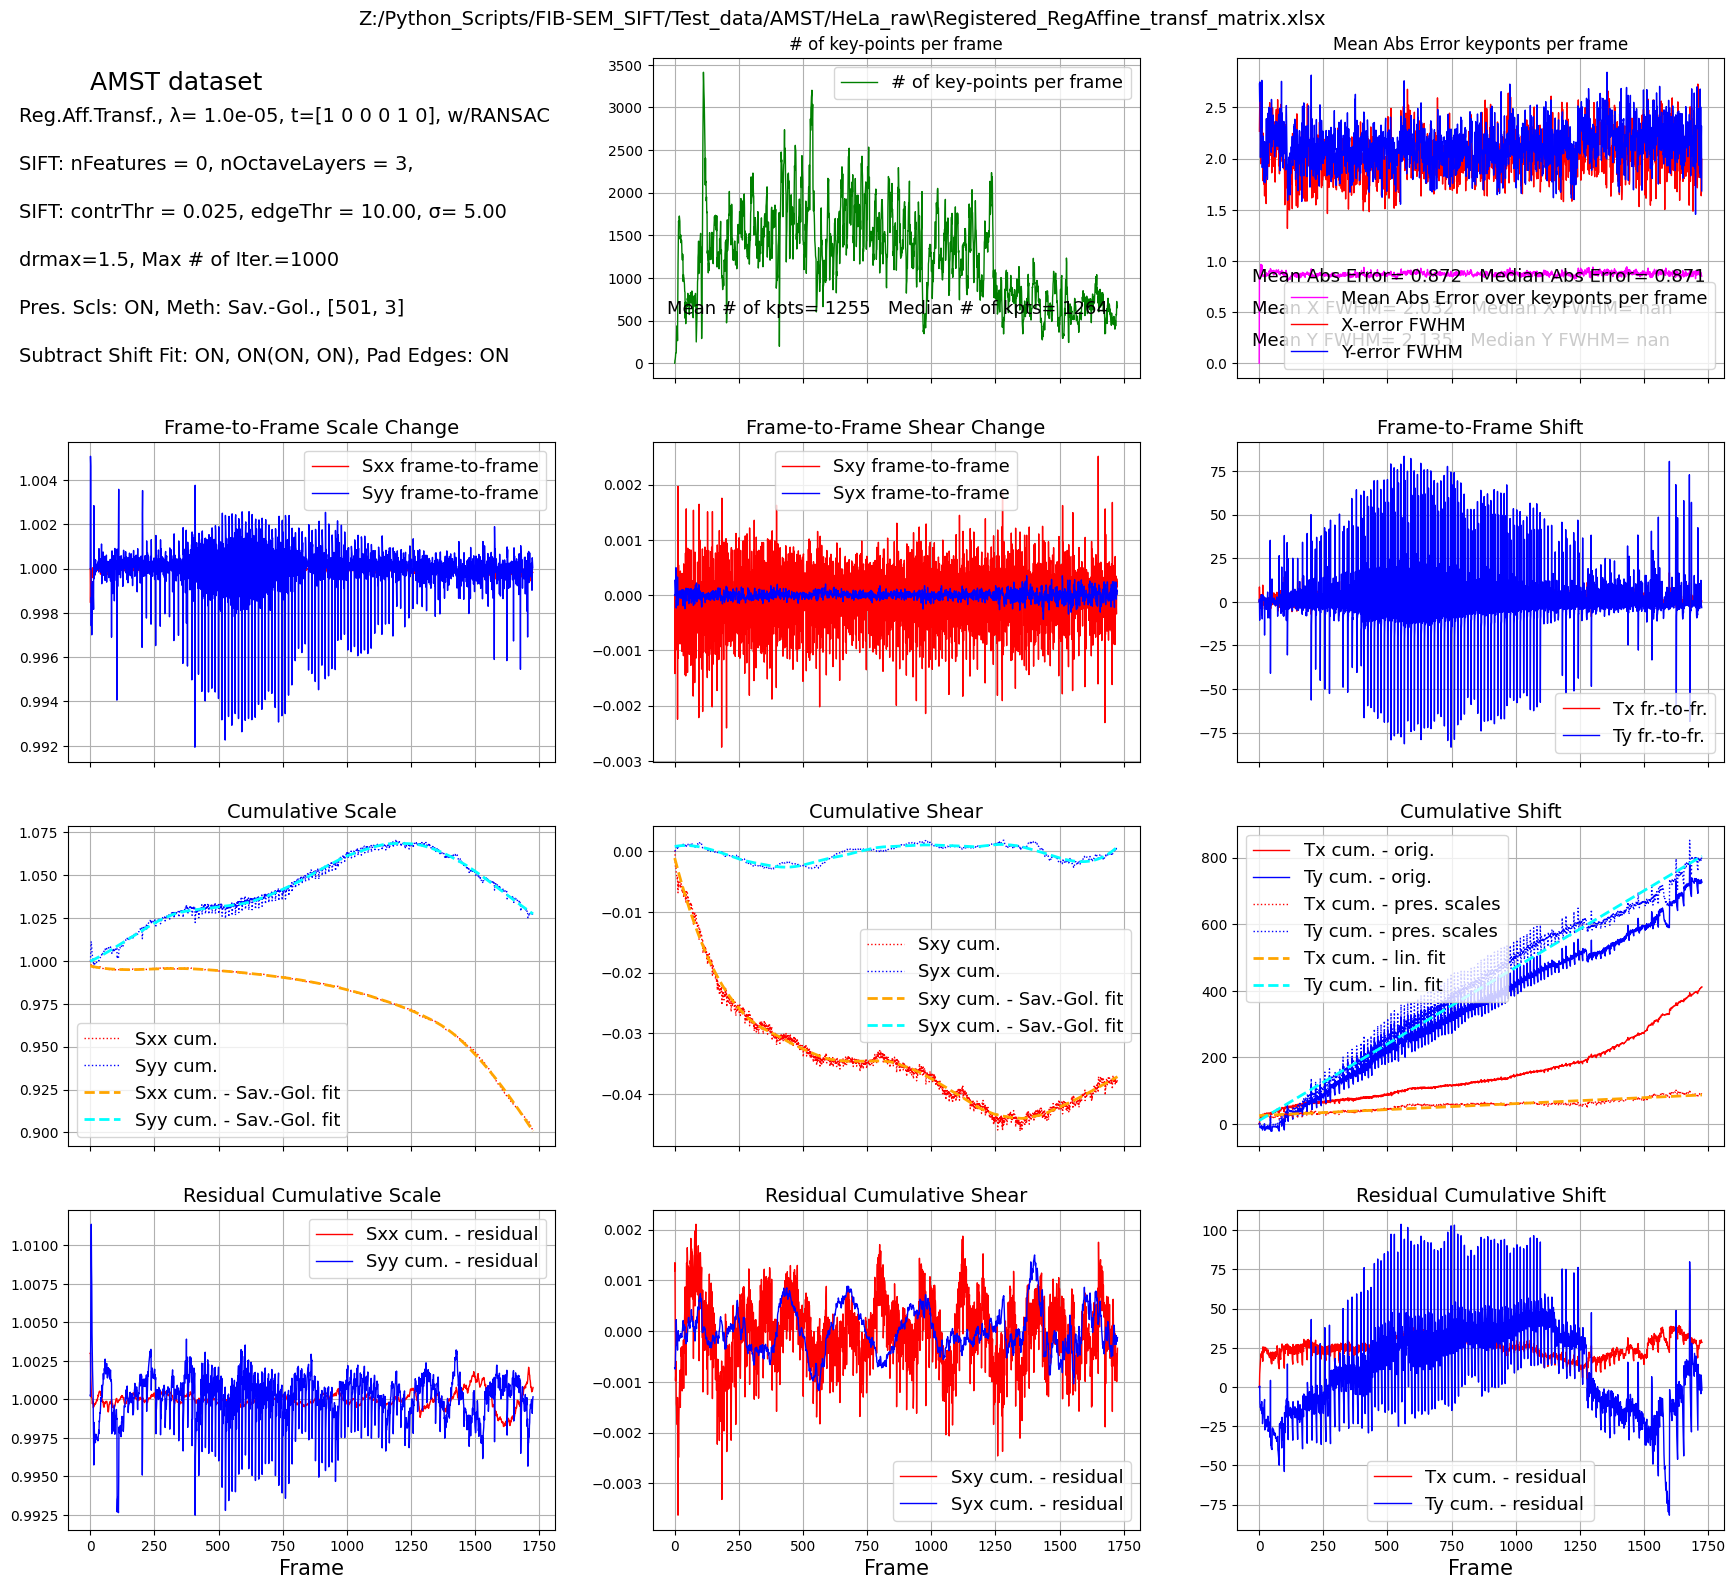

In [10]:
%%time

# Step 3: Extract Key Points and Descriptors using DASK Distributed
t1 = time.time()
print('Step 3: Extract Key Points and Descriptors')
with Client() as client:
    fnms = test_dataset.extract_keypoints(DASK_client = client)   
t2 = time.time()
print('Step 3: Elapsed time: {:.2f} seconds'.format(t2 - t1))
print('')

# Step 4: Select good matches and extract transformation parameters using DASK Distributed
matcher_str = 'BF' if BFMatcher else 'FLANN'
print('Step 4: Select Good Matches with ' + matcher_str + ' matcher')
print('Step 4: using ' + test_dataset.TransformType.__name__ + ' Transformation Model with ' + solver + ' solver')
if test_dataset.TransformType == RegularizedAffineTransform:
    print('Step 4: ' + test_dataset.TransformType.__name__ + ' parameters:')
    print('Step 4: Regularization matrix: ')
    print(test_dataset.l2_matrix)
    print('Step 4: Target Solution: ', test_dataset.targ_vector)

with Client() as client:
    results_s4 = test_dataset.determine_transformations(DASK_client = client)
t3 = time.time()
print('Step 4: Elapsed time: {:.2f} seconds'.format(t3 - t2))

tr_matr_cum_residual, tr_matr_cum_xlsx_file = test_dataset.process_transformation_matrix()
generate_report_transf_matrix_from_xlsx(tr_matr_cum_xlsx_file)

In [11]:
# here is an example of how the previous step can be modified easily without having to re-do all previous steps
# this will calculate the cumulative transformation matrix WITHOT modifying the object property subtract_linear_fit
# so this change will NOT propagate.
# tr_matr_cum_residual = test_dataset.process_transformation_matrix(subtract_linear_fit = [False, True])
# if you want to make permanet change, then you should do this:
# test_dataset.subtract_linear_fit = [False, True]
# tr_matr_cum_residual = test_dataset.process_transformation_matrix()


# Step 5: Search for frames with no (or low # of) matches and possibly remove them.

In [12]:
thr_npt = 3   # consider frame with less than 3 Key Points for removal
tr_matr_cum_residual = test_dataset.check_for_nomatch_frames(thr_npt, **SIFT_kwargs)

Frames with no matches to the next frame:   0
No frames selected for removal


# Step 6: Recall or Save the Intermediate Data (KeyPoints, Matches, Transf.Matrix, etc.) from / into spreadsheets and a binary files.  Remove the intermediate KeyPoint/Descriptor files.

In [13]:
recall_the_data = False          # if False, the data will be saved. if True, the data will be recalled

dump_filename = os.path.join(data_dir, test_dataset.fnm_reg.replace('.mrc', '_params.bin'))

if recall_the_data:
    print(time.strftime('%Y/%m/%d  %H:%M:%S: Parameters recalled from the file: '), dump_filename)
    test_dataset = FIBSEM_dataset(fls, recall_parameters=True, dump_filename=dump_filename, **SIFT_kwargs)
    
else:
    saved_dump_filename = test_dataset.save_parameters(dump_filename=dump_filename)
    print(time.strftime('%Y/%m/%d  %H:%M:%S: Parameters saved into the file: '), saved_dump_filename)

2025/09/05  11:45:13: Parameters saved into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\Registered_RegAffine_params.bin


In [14]:
remove_key_points_data = False   # if True, the binary files with intermediate keypoints data for each frame will be removed

# Remove temporary files
if remove_key_points_data:
    # Remove the keypoint/ descriptor files
    for fnm in tqdm(test_dataset.fnms, desc='Removing KeyPoint/Descriptor Files: '):
        try:
            os.remove(os.path.join(data_dir, fnm))
        except:
            pass
    for fnm in tqdm(test_dataset.fnms_matches, desc='Removing Matched KeyPoint Files: '):
        try:
            os.remove(os.path.join(data_dir, fnm))
        except:
            pass


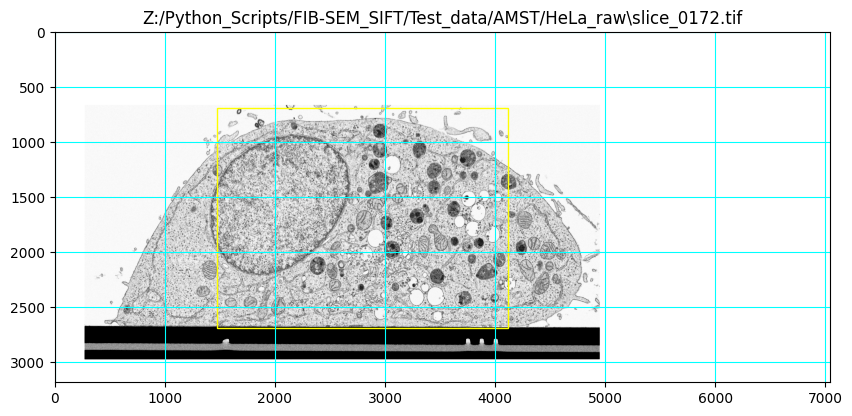

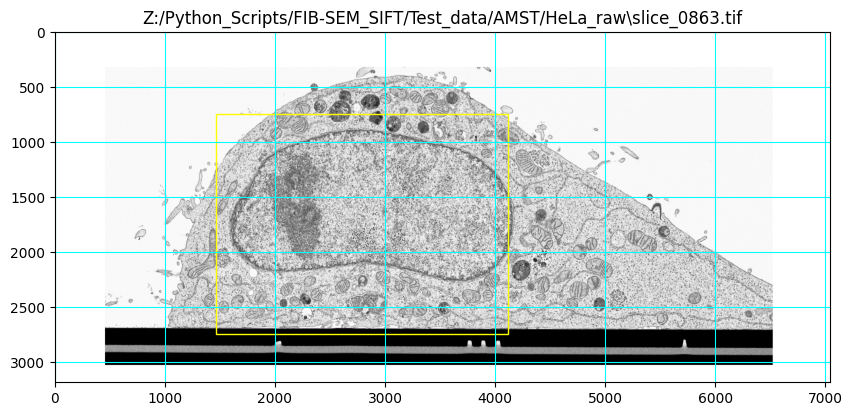

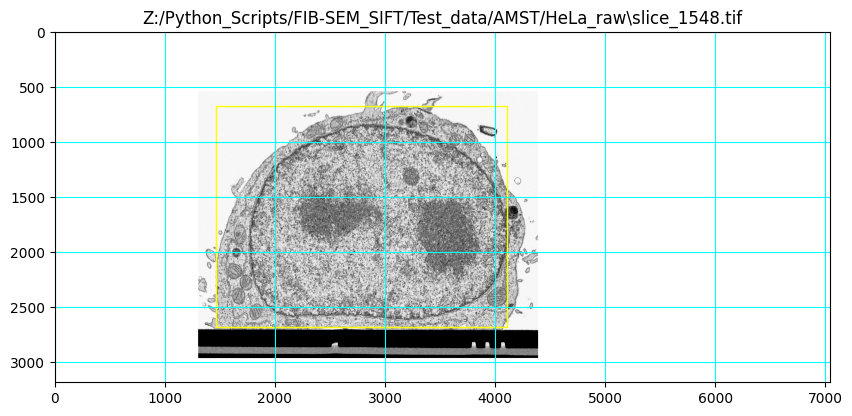

In [15]:
# evaluation_box = [250, 2000, 1450, 2650]      # optional evaluation box for defining the area over which the registration quality
# test_dataset.show_eval_box(evaluation_box = evaluation_box, invert_data=False)
#
# default frames are three frames: 10% from the start, 50% from the start, and 90% from the start
# alternatively you can set any list of frame indecis by using keyword frame_indices
# for example:0
# test_dataset.show_eval_box(frame_indices=[1, 100, 850], evaluation_box = evaluation_box, invert_data=False)
#

evaluation_box = [375, 2000, 1450, 2650]
test_dataset.show_eval_box(evaluation_box = evaluation_box,
                           invert_data=False, flipY=True)

# Step 7: Transform and Save the FIB-SEM data

Step 7: Transform and Save the FIB-SEM data
2025/09/05  11:45:36  DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:8787/status to monitor DASK progress
Transforming and Saving Intermediate Registered Frames


Setting up parameter sets:   0%|          | 0/1727 [00:00<?, ?it/s]

2025/09/05  11:45:37   Transform and Save Chunks of Frames: Starting DASK jobs


C:\Users\labadmin\anaconda3\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 40.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2025/09/05  11:51:16   Finished DASK jobs
Analyzing Registration Quality
2025/09/05  11:51:17   Analyzing Frame Registration: Starting DASK jobs
2025/09/05  12:05:48   Finished DASK jobs
2025/09/05  12:05:57   Saving the Registration Quality Statistics into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\Registered_RegAffine_RegistrationQuality.xlsx
Creating Dask Array Stack
The resulting stack shape will be  nx=7043, ny=3182, nz=1727,  data type: <class 'numpy.int16'>
Voxel destreak_mrc_stackSize (nm): 8.000000 x 8.000000 x 8.000000
2025/09/05  12:05:59   Saving dataset into MRC file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\Registered_RegAffine.mrc
The resulting stack will saved using mrc_mode=1,  data type= <class 'numpy.int16'>


Saving Frames into MRC File:   0%|          | 0/1727 [00:00<?, ?it/s]

Removing Intermediate Registered Frame Files:   0%|          | 0/1727 [00:00<?, ?it/s]

CPU times: total: 15min 44s
Wall time: 1h 7min 22s


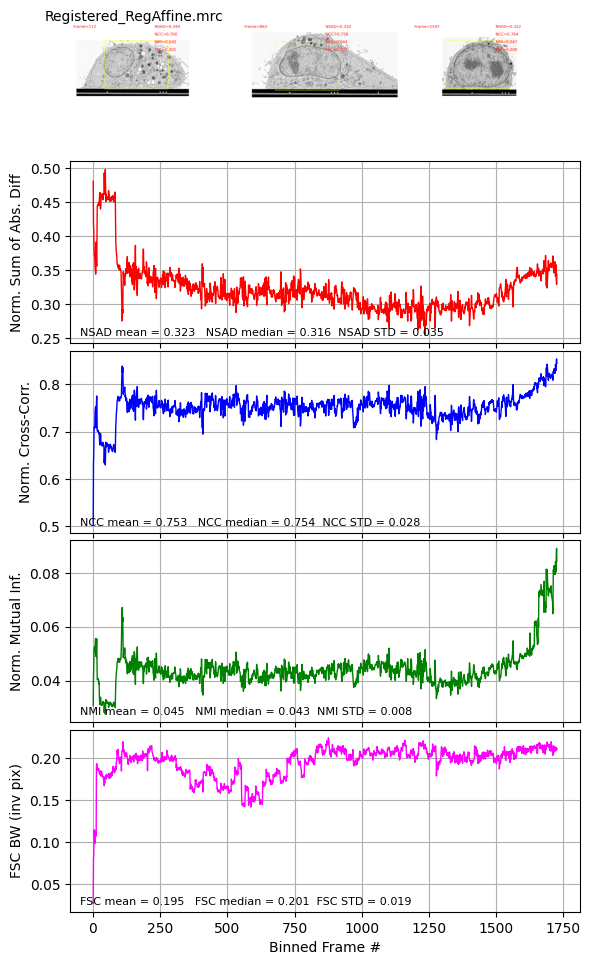

In [16]:
%%time

print('Step 7: Transform and Save the FIB-SEM data')

test_dataset.fnm_reg = 'Registered_RegAffine.mrc'
evaluation_box = [375, 2000, 1430, 2650]
with Client() as client:
    reg_summary_regaffine, reg_summary_regaffine_xlsx = test_dataset.transform_and_save(DASK_client = client,
                                                        flipY=True,
                                                        save_transformed_dataset = True,
                                                        save_registration_summary = True,
                                                        evaluation_box = evaluation_box,
                                                        fnm_types = ['mrc']) # following additional keys are available:
                                                #
                                                # perform_transformation (default=True). Set to false if you want to save the raw data into a single stack
                                                # and evaluare raw registration quality
                                                #
                                                # invert_data (default=False). Set to True if you want to invert te data
                                                #
                                                # evaluation_box (default [0, -1, 0, -1]. Set boundaries ([top, height, left, width]))
                                                # of the image subset to be used for registration quality evaluation

generate_report_from_xls_registration_summary(reg_summary_regaffine_xlsx, sample_frames_layout = 'horizontal')

Step 4: Select Good Matches with FLANN matcher
Step 4: using AffineTransform Transformation Model with RANSAC solver
2025/09/05  12:53:00  DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:8787/status to monitor DASK progress
2025/09/05  12:53:00   Using DASK distributed
Mean Number of Keypoints : 1255


Calculating Cummilative Transformation Matrix:   0%|          | 0/1726 [00:00<?, ?it/s]

Recalculating the shifts for preserved scales:   0%|          | 0/1726 [00:00<?, ?it/s]

Parameters saved into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\Registered_Affine_params.bin
Step 7: Transform and Save the FIB-SEM data
2025/09/05  13:04:46  DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:8787/status to monitor DASK progress
Transforming and Saving Intermediate Registered Frames


Setting up parameter sets:   0%|          | 0/1727 [00:00<?, ?it/s]

2025/09/05  13:04:47   Transform and Save Chunks of Frames: Starting DASK jobs


C:\Users\labadmin\anaconda3\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 40.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2025/09/05  13:10:26   Finished DASK jobs
Analyzing Registration Quality
2025/09/05  13:10:26   Analyzing Frame Registration: Starting DASK jobs
2025/09/05  13:24:58   Finished DASK jobs
2025/09/05  13:25:08   Saving the Registration Quality Statistics into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\Registered_Affine_RegistrationQuality.xlsx
Registered data set is NOT saved into a file


Removing Intermediate Registered Frame Files:   0%|          | 0/1727 [00:00<?, ?it/s]

CPU times: total: 3min 6s
Wall time: 33min


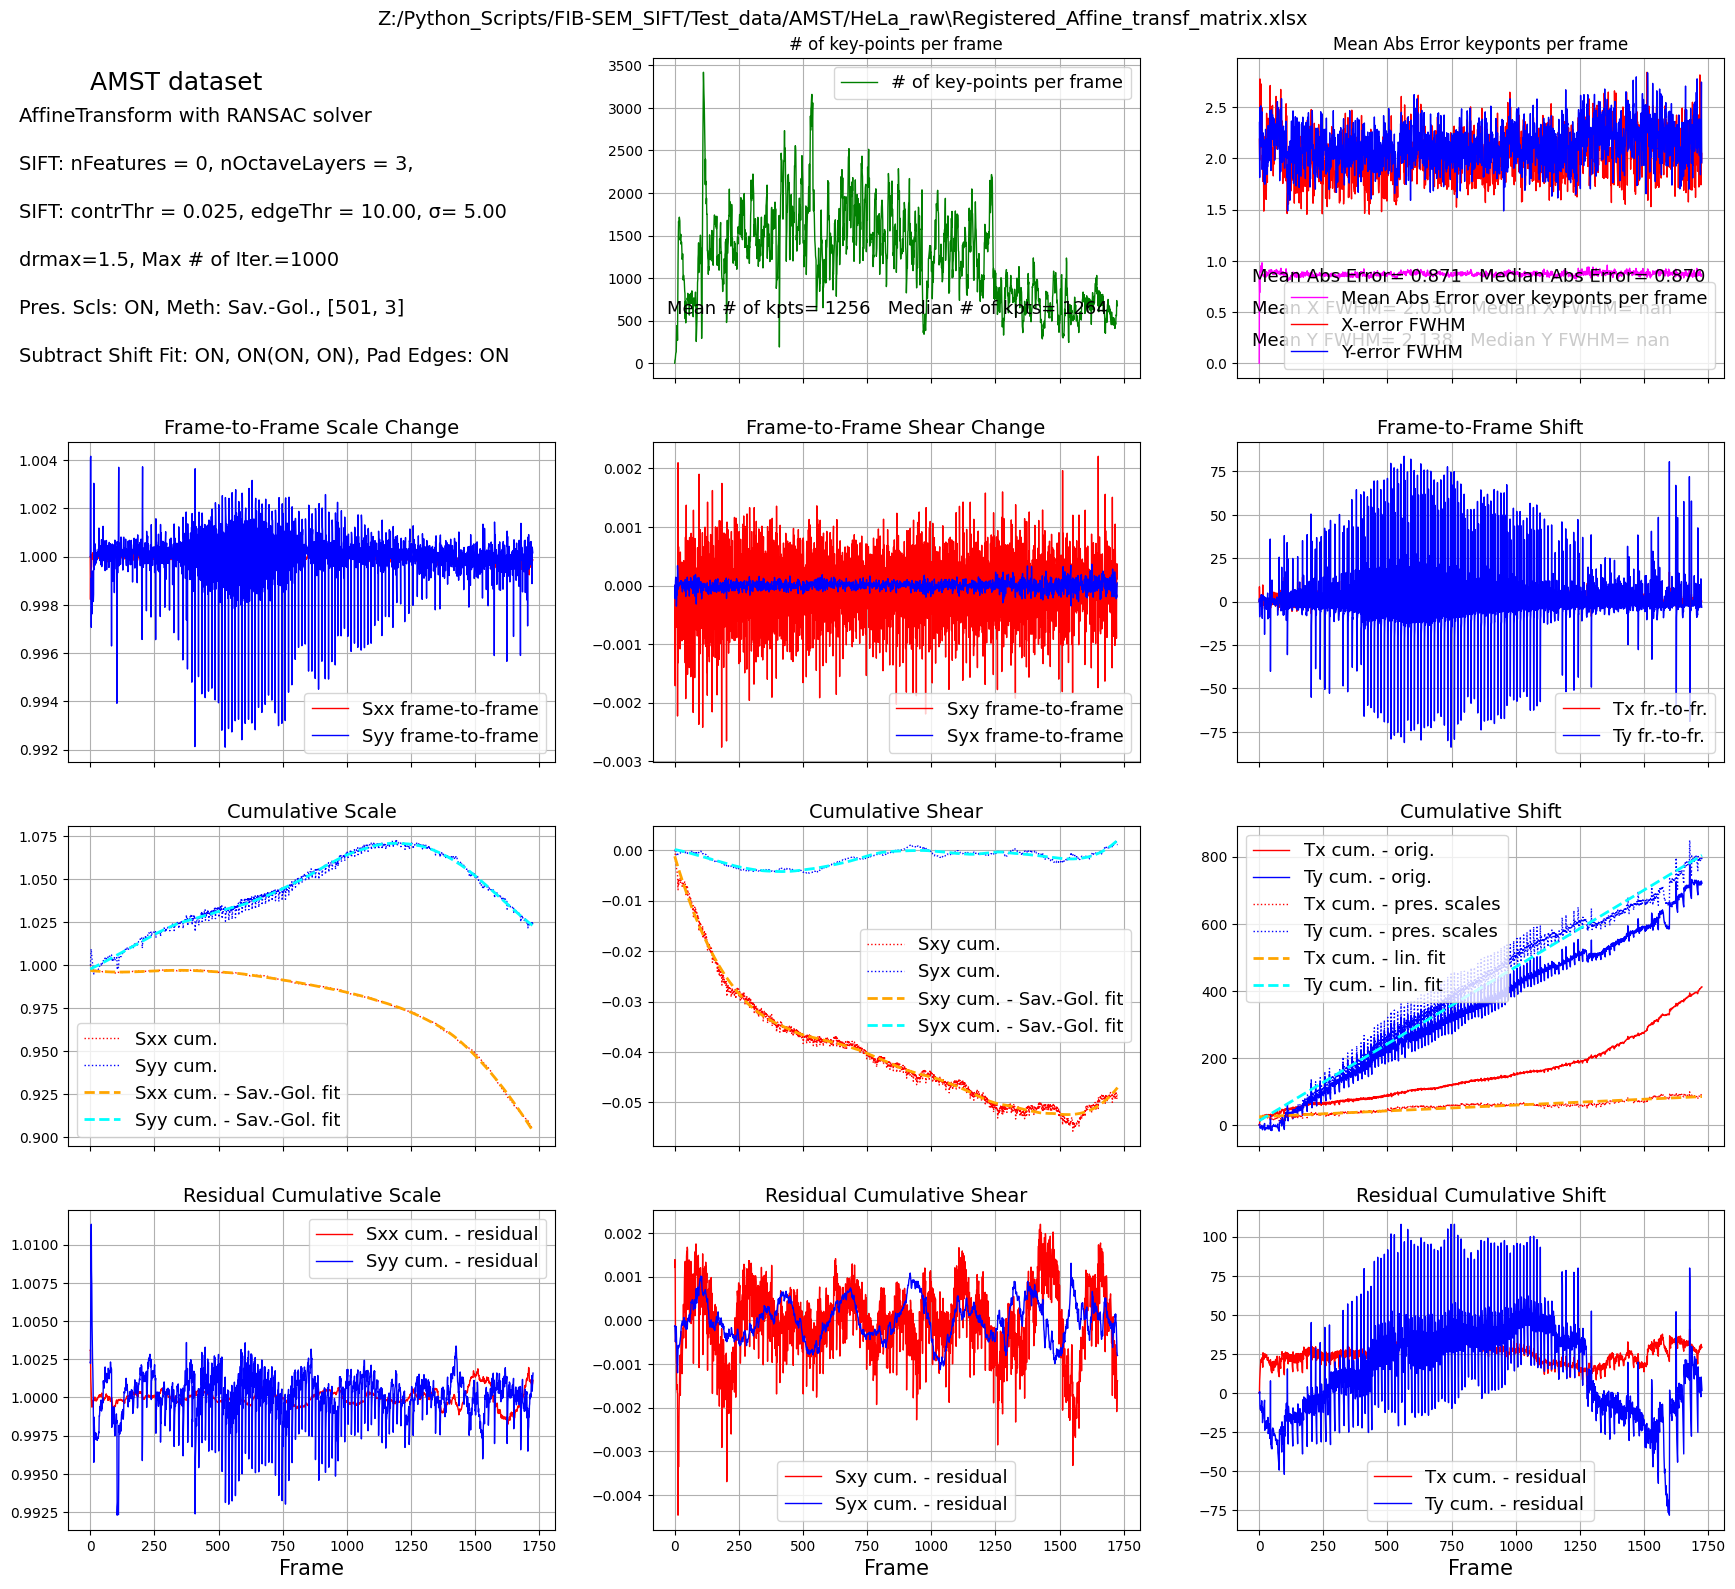

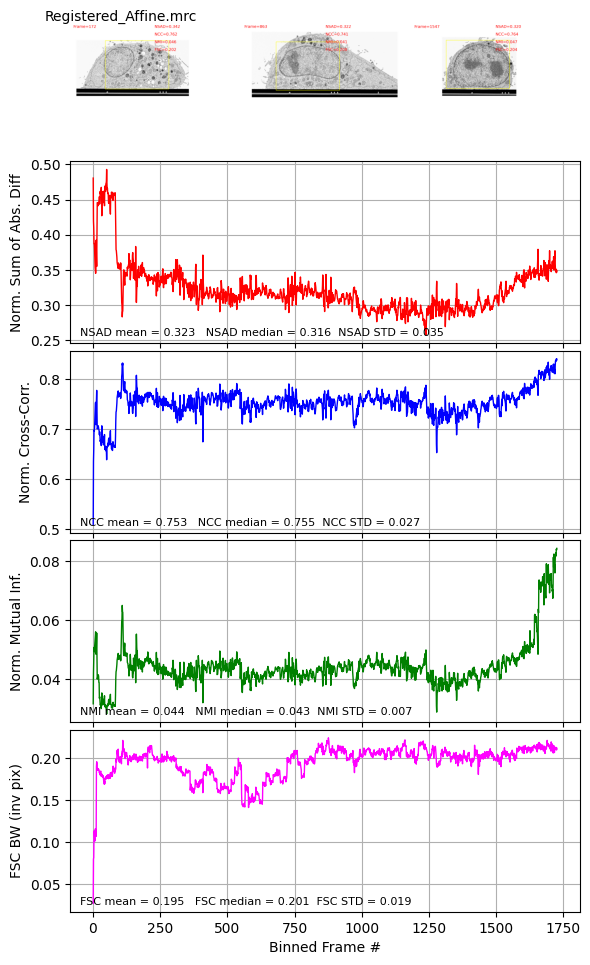

In [17]:
%%time
#TransformType = ShiftTransform                #  only x-shift and y-shift
#TransformType = XScaleShiftTransform          #  x-scale, x-shift, y-shift
#TransformType = ScaleShiftTransform           #  x-scale, y-scale, x-shift, y-shift
#TransformType = AffineTransform               #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
#TransformType = RegularizedAffineTransform     #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
                                                # with regularization on deviation from ShiftTransform
test_dataset.TransformType = AffineTransform
SIFT_kwargs['TransformType'] = test_dataset.TransformType
test_dataset.fnm_reg = 'Registered_Affine.mrc'

# Step 4: Select good matches and extract transformation parameters using DASK Distributed
matcher_str = 'BF' if BFMatcher else 'FLANN'
print('Step 4: Select Good Matches with ' + matcher_str + ' matcher')
print('Step 4: using ' + test_dataset.TransformType.__name__ + ' Transformation Model with ' + solver + ' solver')
if test_dataset.TransformType == RegularizedAffineTransform:
    print('Step 4: ' + test_dataset.TransformType.__name__ + ' parameters:')
    print('Step 4: Regularization matrix: ')
    print(test_dataset.l2_matrix)
    print('Step 4: Target Solution: ', test_dataset.targ_vector)

with Client() as client:
    results_s4 = test_dataset.determine_transformations(DASK_client = client)

tr_matr_cum_residual, tr_matr_cum_xlsx_file = test_dataset.process_transformation_matrix()
generate_report_transf_matrix_from_xlsx(tr_matr_cum_xlsx_file)

dump_filename = os.path.join(data_dir, test_dataset.fnm_reg.replace('.mrc', '_params.bin'))
saved_dump_file = test_dataset.save_parameters(dump_file=dump_filename)
print('Parameters saved into the file: ', saved_dump_file)

print('Step 7: Transform and Save the FIB-SEM data')

evaluation_box = [375, 2000, 1450, 2650]       # optional evaluation box for defining the area over which the registration quality
                                                # is evaluated. It can be checked in the step above. The use 
                                                # of the method below would be:

with Client() as client:
    reg_summary_affine, reg_summary_affine_xlsx = test_dataset.transform_and_save(DASK_client = client,
                                                                              flipY=True,
                                                                              save_transformed_dataset = False,
                                                                              save_registration_summary = True,
                                                                              evaluation_box = evaluation_box,
                                                                              fnm_types = ['mrc'])
generate_report_from_xls_registration_summary(reg_summary_affine_xlsx, sample_frames_layout = 'horizontal')

Step 4: Select Good Matches with FLANN matcher
Step 4: using ScaleShiftTransform Transformation Model with RANSAC solver
2025/09/05  13:26:04  DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:8787/status to monitor DASK progress
2025/09/05  13:26:04   Using DASK distributed
Mean Number of Keypoints : 1226


Calculating Cummilative Transformation Matrix:   0%|          | 0/1726 [00:00<?, ?it/s]

Recalculating the shifts for preserved scales:   0%|          | 0/1726 [00:00<?, ?it/s]

Parameters saved into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\Registered_ScaleShift_params.bin
Step 7: Transform and Save the FIB-SEM data
2025/09/05  13:34:13  DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:8787/status to monitor DASK progress
Transforming and Saving Intermediate Registered Frames


Setting up parameter sets:   0%|          | 0/1727 [00:00<?, ?it/s]

2025/09/05  13:34:15   Transform and Save Chunks of Frames: Starting DASK jobs


C:\Users\labadmin\anaconda3\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 40.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2025/09/05  13:39:48   Finished DASK jobs
Analyzing Registration Quality
2025/09/05  13:39:49   Analyzing Frame Registration: Starting DASK jobs
2025/09/05  13:54:07   Finished DASK jobs
2025/09/05  13:54:18   Saving the Registration Quality Statistics into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\Registered_ScaleShift_RegistrationQuality.xlsx
Registered data set is NOT saved into a file


Removing Intermediate Registered Frame Files:   0%|          | 0/1727 [00:00<?, ?it/s]

CPU times: total: 2min 43s
Wall time: 29min 6s


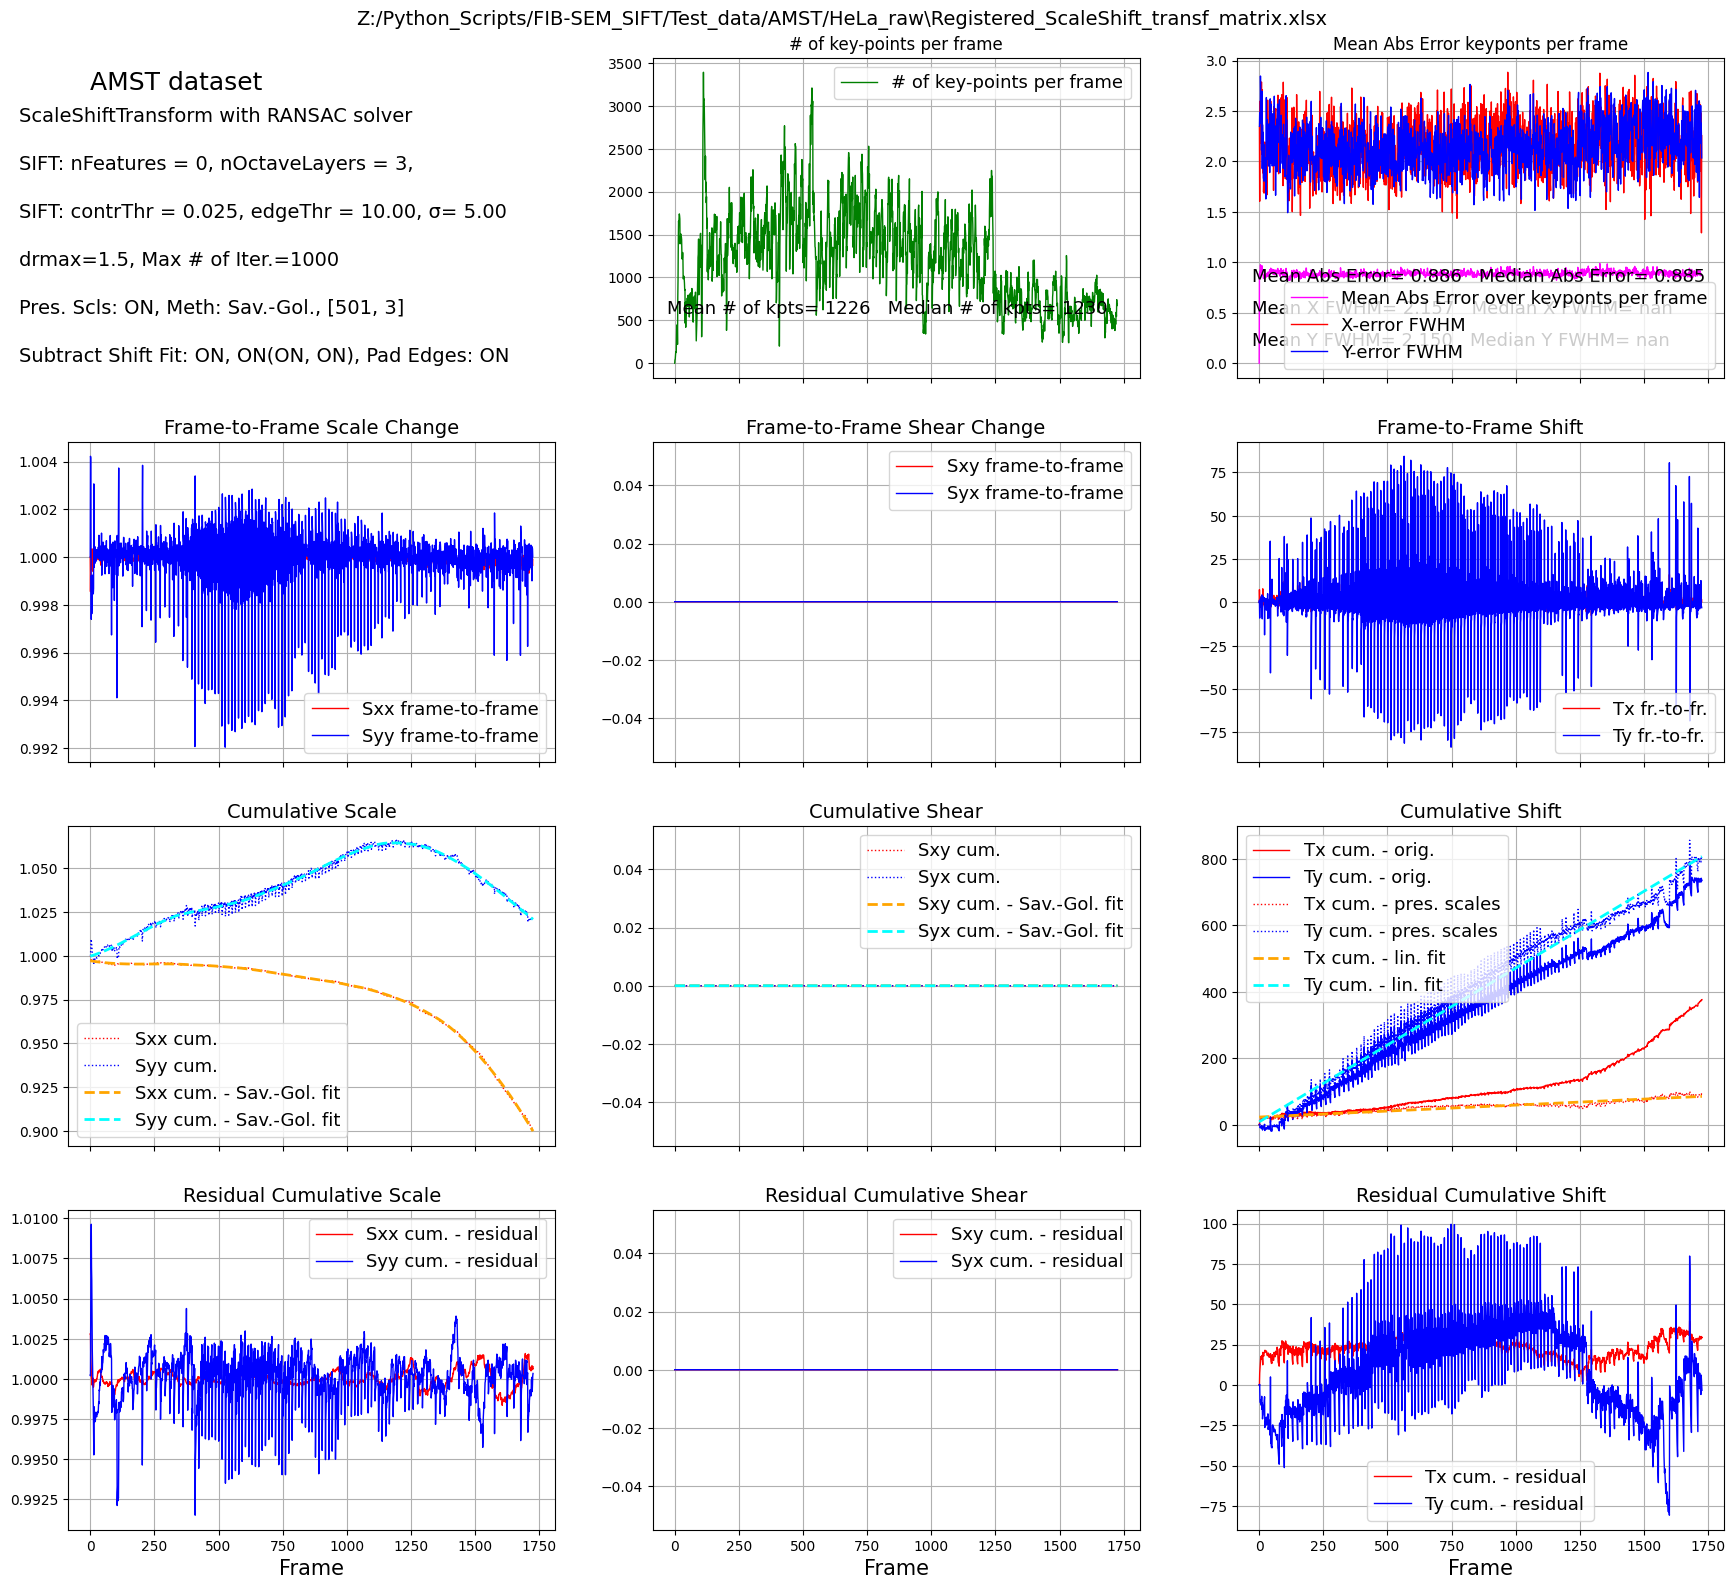

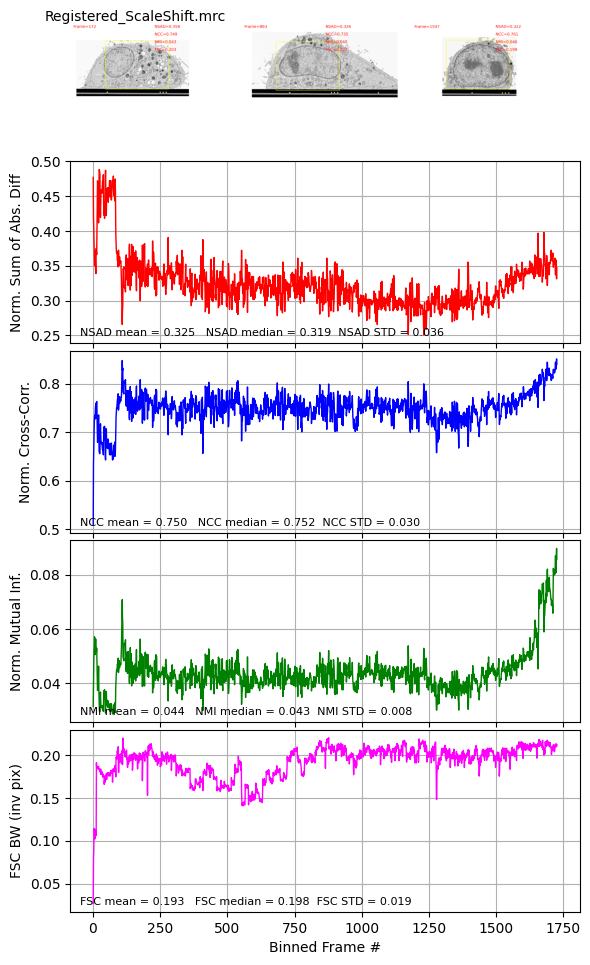

In [18]:
%%time
#TransformType = ShiftTransform                #  only x-shift and y-shift
#TransformType = XScaleShiftTransform          #  x-scale, x-shift, y-shift
#TransformType = ScaleShiftTransform           #  x-scale, y-scale, x-shift, y-shift
#TransformType = AffineTransform               #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
#TransformType = RegularizedAffineTransform     #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
                                                # with regularization on deviation from ShiftTransform
test_dataset.TransformType = ScaleShiftTransform
SIFT_kwargs['TransformType'] = test_dataset.TransformType
test_dataset.fnm_reg = 'Registered_ScaleShift.mrc'

# Step 4: Select good matches and extract transformation parameters using DASK Distributed
matcher_str = 'BF' if BFMatcher else 'FLANN'
print('Step 4: Select Good Matches with ' + matcher_str + ' matcher')
print('Step 4: using ' + test_dataset.TransformType.__name__ + ' Transformation Model with ' + solver + ' solver')
if test_dataset.TransformType == RegularizedAffineTransform:
    print('Step 4: ' + test_dataset.TransformType.__name__ + ' parameters:')
    print('Step 4: Regularization matrix: ')
    print(test_dataset.l2_matrix)
    print('Step 4: Target Solution: ', test_dataset.targ_vector)

with Client() as client:
    results_s4 = test_dataset.determine_transformations(DASK_client = client)

tr_matr_cum_residual, tr_matr_cum_xlsx_file = test_dataset.process_transformation_matrix()
generate_report_transf_matrix_from_xlsx(tr_matr_cum_xlsx_file)

dump_filename = os.path.join(data_dir, test_dataset.fnm_reg.replace('.mrc', '_params.bin'))
saved_dump_file = test_dataset.save_parameters(dump_file=dump_filename)
print('Parameters saved into the file: ', saved_dump_file)

print('Step 7: Transform and Save the FIB-SEM data')

evaluation_box = [375, 2000, 1450, 2650]       # optional evaluation box for defining the area over which the registration quality
                                                # is evaluated. It can be checked in the step above. The use 
                                                # of the method below would be:

with Client() as client:
    reg_summary_scaleshift, reg_summary_scaleshift_xlsx = test_dataset.transform_and_save(DASK_client = client,
                                                                                      flipY=True,
                                                                                    save_transformed_dataset = False,
                                                                                    save_registration_summary = True,
                                                                                    evaluation_box = evaluation_box,
                                                                                      fnm_types = ['mrc'])
generate_report_from_xls_registration_summary(reg_summary_scaleshift_xlsx, sample_frames_layout = 'horizontal')

Step 4: Select Good Matches with FLANN matcher
Step 4: using ShiftTransform Transformation Model with RANSAC solver
2025/09/05  13:56:04  DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:8787/status to monitor DASK progress
2025/09/05  13:56:04   Using DASK distributed
Mean Number of Keypoints : 1142


Calculating Cummilative Transformation Matrix:   0%|          | 0/1726 [00:00<?, ?it/s]

Recalculating the shifts for preserved scales:   0%|          | 0/1726 [00:00<?, ?it/s]

Parameters saved into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\Registered_Shift_params.bin
Step 7: Transform and Save the FIB-SEM data
2025/09/05  14:03:11  DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:8787/status to monitor DASK progress
Transforming and Saving Intermediate Registered Frames


Setting up parameter sets:   0%|          | 0/1727 [00:00<?, ?it/s]

2025/09/05  14:03:13   Transform and Save Chunks of Frames: Starting DASK jobs


C:\Users\labadmin\anaconda3\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 40.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2025/09/05  14:09:07   Finished DASK jobs
Analyzing Registration Quality
2025/09/05  14:09:08   Analyzing Frame Registration: Starting DASK jobs
2025/09/05  14:24:32   Finished DASK jobs
2025/09/05  14:24:41   Saving the Registration Quality Statistics into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\Registered_Shift_RegistrationQuality.xlsx
Registered data set is NOT saved into a file


Removing Intermediate Registered Frame Files:   0%|          | 0/1727 [00:00<?, ?it/s]

CPU times: total: 4min 41s
Wall time: 29min 35s


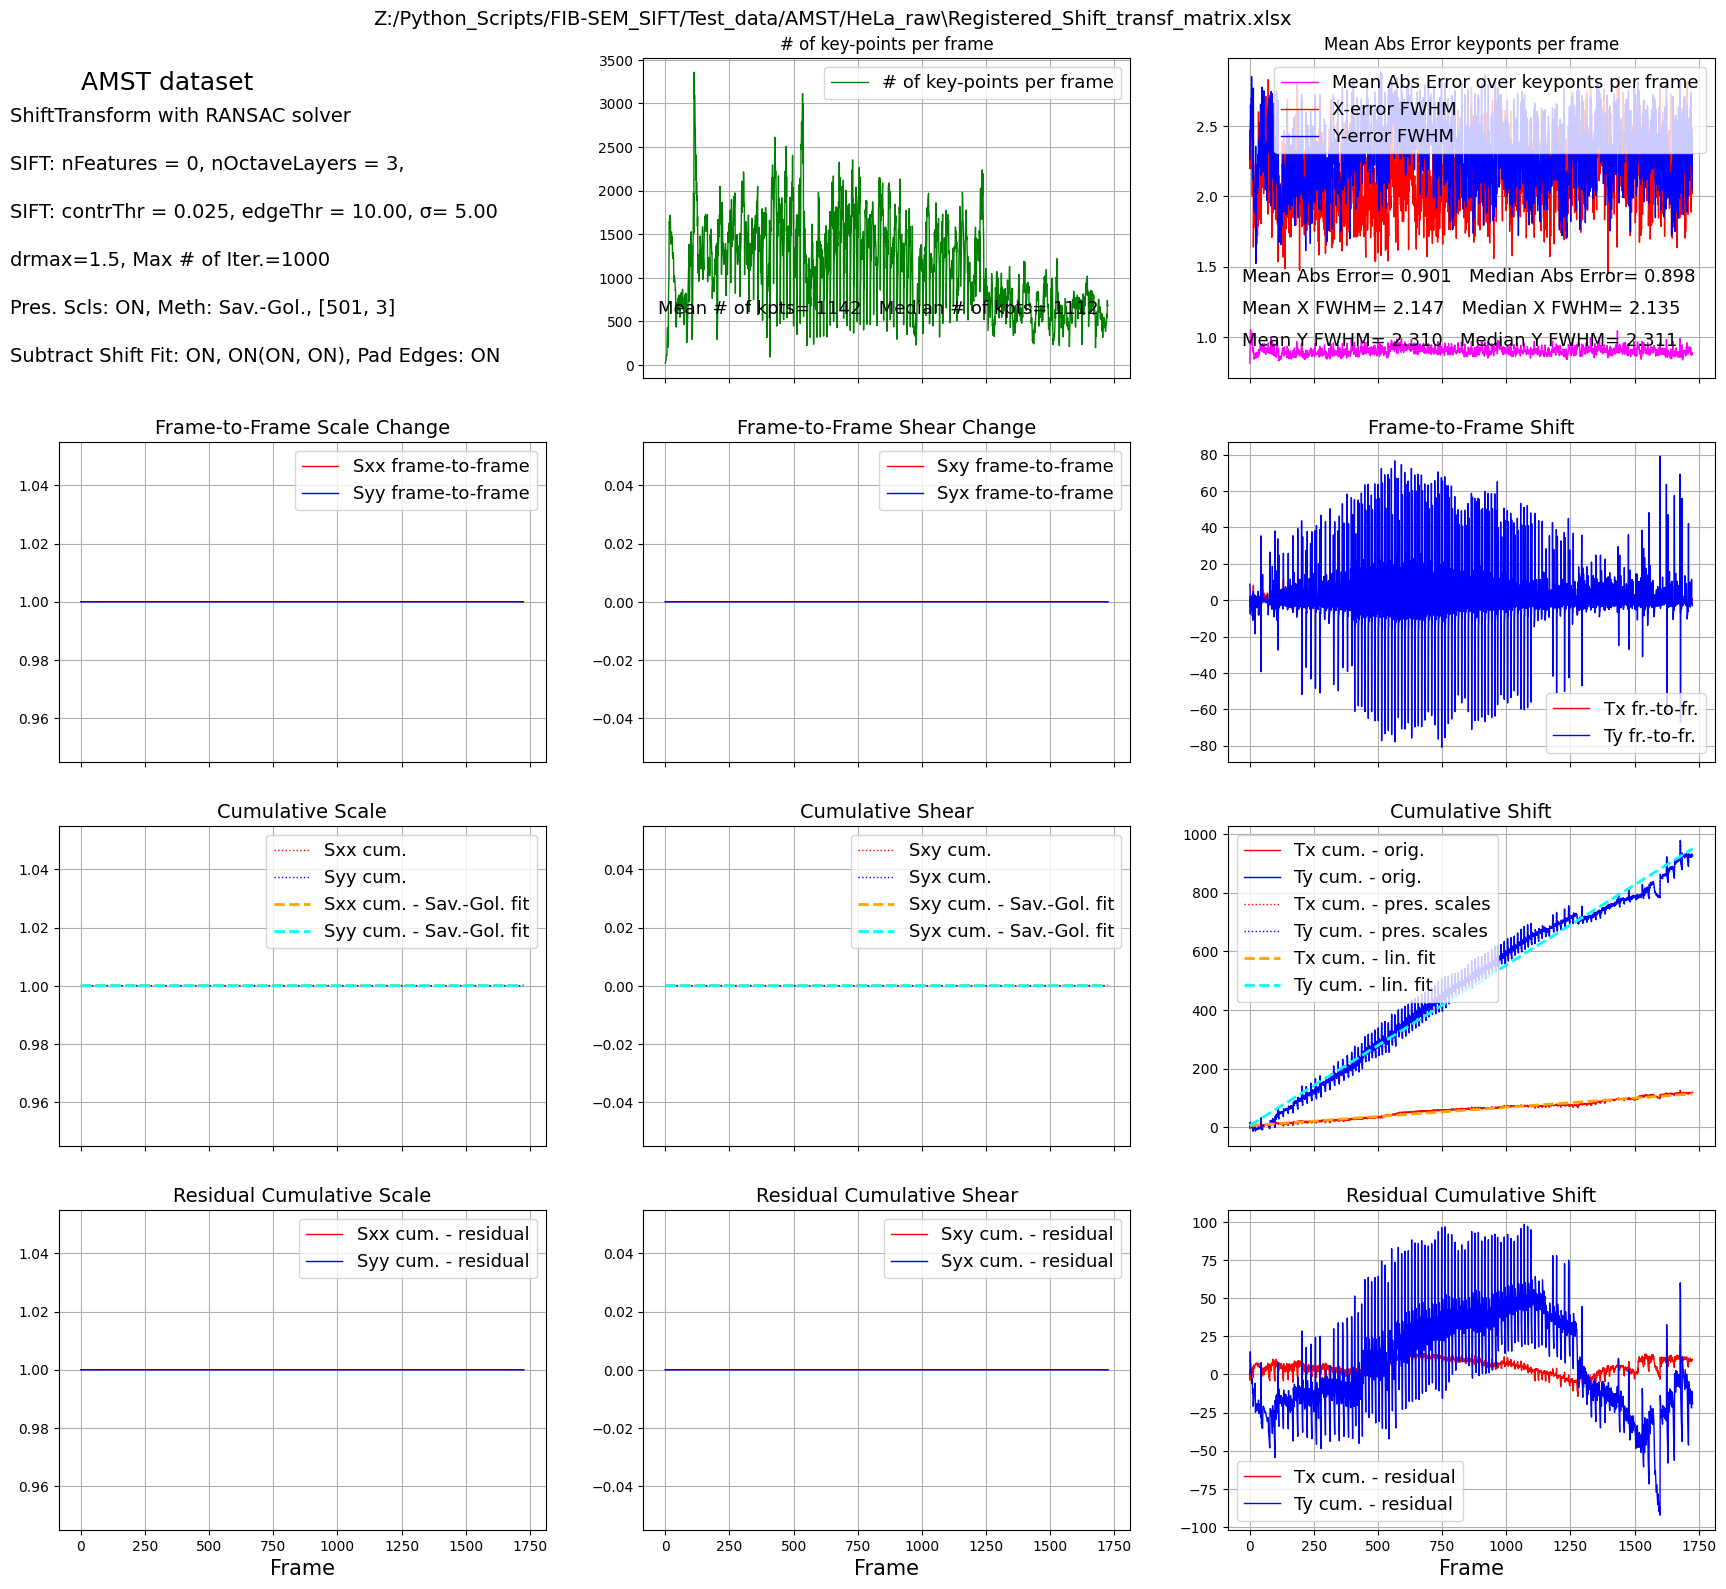

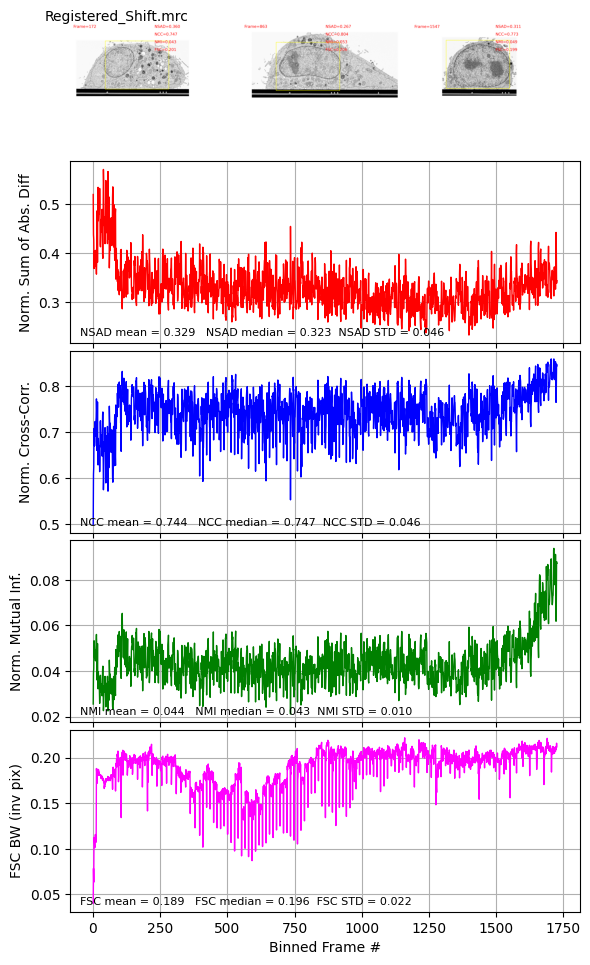

In [19]:
%%time
#TransformType = ShiftTransform                #  only x-shift and y-shift
#TransformType = XScaleShiftTransform          #  x-scale, x-shift, y-shift
#TransformType = ScaleShiftTransform           #  x-scale, y-scale, x-shift, y-shift
#TransformType = AffineTransform               #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
#TransformType = RegularizedAffineTransform     #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
                                                # with regularization on deviation from ShiftTransform
test_dataset.TransformType = ShiftTransform
SIFT_kwargs['TransformType'] = test_dataset.TransformType
test_dataset.fnm_reg = 'Registered_Shift.mrc'

# Step 4: Select good matches and extract transformation parameters using DASK Distributed
matcher_str = 'BF' if BFMatcher else 'FLANN'
print('Step 4: Select Good Matches with ' + matcher_str + ' matcher')
print('Step 4: using ' + test_dataset.TransformType.__name__ + ' Transformation Model with ' + solver + ' solver')
if test_dataset.TransformType == RegularizedAffineTransform:
    print('Step 4: ' + test_dataset.TransformType.__name__ + ' parameters:')
    print('Step 4: Regularization matrix: ')
    print(test_dataset.l2_matrix)
    print('Step 4: Target Solution: ', test_dataset.targ_vector)
    
with Client() as client:
    results_s4 = test_dataset.determine_transformations(DASK_client = client)

tr_matr_cum_residual, tr_matr_cum_xlsx_file = test_dataset.process_transformation_matrix()
generate_report_transf_matrix_from_xlsx(tr_matr_cum_xlsx_file)

dump_filename = os.path.join(data_dir, test_dataset.fnm_reg.replace('.mrc', '_params.bin'))
saved_dump_file = test_dataset.save_parameters(dump_file=dump_filename)
print('Parameters saved into the file: ', saved_dump_file)

print('Step 7: Transform and Save the FIB-SEM data')

evaluation_box = [375, 2000, 1450, 2650]       # optional evaluation box for defining the area over which the registration quality
                                                # is evaluated. It can be checked in the step above. The use 
                                                # of the method below would be:

with Client() as client:
    reg_summary_shift, reg_summary_shift_xlsx = test_dataset.transform_and_save(DASK_client = client,
                                                                            flipY=True,
                                                                            save_transformed_dataset = False,
                                                                            save_registration_summary = True,
                                                                            evaluation_box = evaluation_box,
                                                                            fnm_types = ['mrc'])
generate_report_from_xls_registration_summary(reg_summary_shift_xlsx, sample_frames_layout = 'horizontal')

2025/09/05  14:25:45   Registered data will be saved into:  Registered_I16_ShiftTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05.mrc
Total Number of frames:  1727
2025/09/05  14:25:45   DASK client does not exist. Will perform local computations
Evaluating the parameters of FIBSEM data set (data Min/Max, Working Distance, Milling Y Voltage, FOV center positions, Scan Rate, EHT)
Original data is 8-bit, no need to find Min and Max for 8-bit conversion
2025/09/05  14:25:45   Saving the FIBSEM dataset statistics (Min/Max, Mill Rate, FOV Shifts into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\FIBSEM_Data.xlsx
No milling rate data is available, isotropic voxel size is set to 8.00 nm
2025/09/05  14:25:48  DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:8787/status to monitor DASK progress
Transforming and Saving Intermediate Registered Frames


Setting up parameter sets:   0%|          | 0/1727 [00:00<?, ?it/s]

2025/09/05  14:25:52   Transform and Save Chunks of Frames: Starting DASK jobs


C:\Users\labadmin\anaconda3\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 40.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2025/09/05  14:29:29   Finished DASK jobs
Analyzing Registration Quality
2025/09/05  14:29:29   Analyzing Frame Registration: Starting DASK jobs
2025/09/05  14:44:24   Finished DASK jobs
2025/09/05  14:44:38   Saving the Registration Quality Statistics into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\raw_data_orig_RegistrationQuality.xlsx
Registered data set is NOT saved into a file


Removing Intermediate Registered Frame Files:   0%|          | 0/1727 [00:00<?, ?it/s]

CPU times: total: 2min 52s
Wall time: 19min 52s


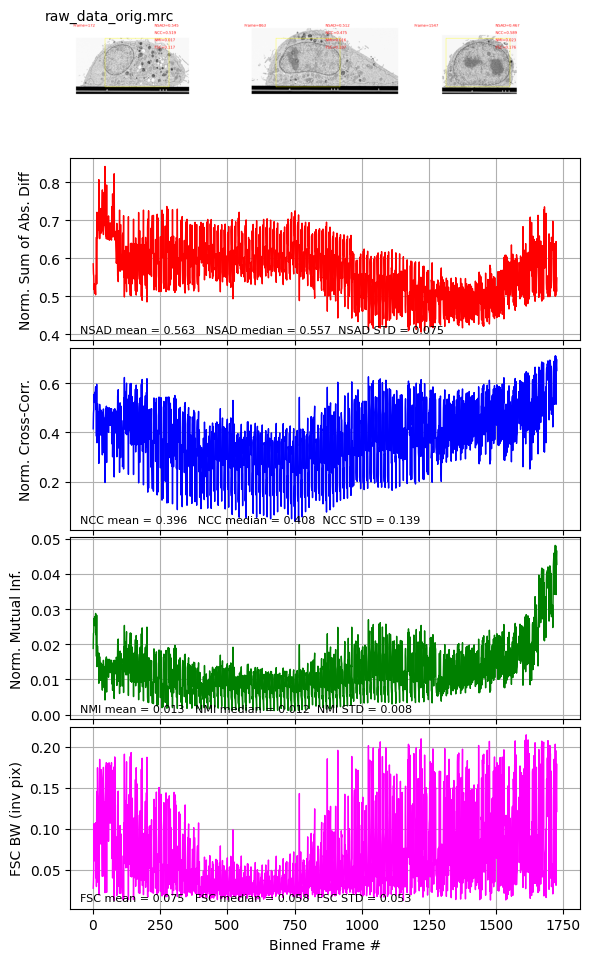

In [20]:
%%time
data_dir_raw = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw'
fls_raw = sorted(glob.glob(os.path.join(data_dir_raw,'*.tif')))
test_dataset = FIBSEM_dataset(fls_raw, **SIFT_kwargs)
test_dataset.data_dir = data_dir_raw
test_dataset.fnm_reg = 'raw_data_orig.mrc'
FIBSEM_Data_raw =  test_dataset.evaluate_FIBSEM_statistics(DASK_client = client)

evaluation_box = [375, 2000, 1450, 2650]       # optional evaluation box for defining the area over which the registration quality
                                                # is evaluated. It can be checked in the step above. The use 
                                                # of the method below would be:

with Client() as client:
    raw_reg_summary, raw_reg_summary_xlsx = test_dataset.transform_and_save(DASK_client = client,
                                                                        invert_data=False,
                                                                        flipY=True,
                                                                        perform_transformation=False,
                                                                        save_transformed_dataset = False,
                                                                        save_registration_summary = True,
                                                                        evaluation_box = evaluation_box,
                                                                        fnm_types = ['mrc'])
generate_report_from_xls_registration_summary(raw_reg_summary_xlsx, sample_frames_layout = 'horizontal')

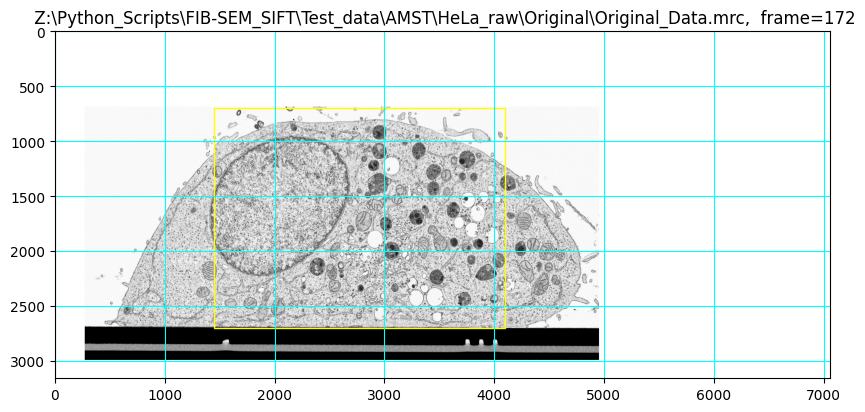

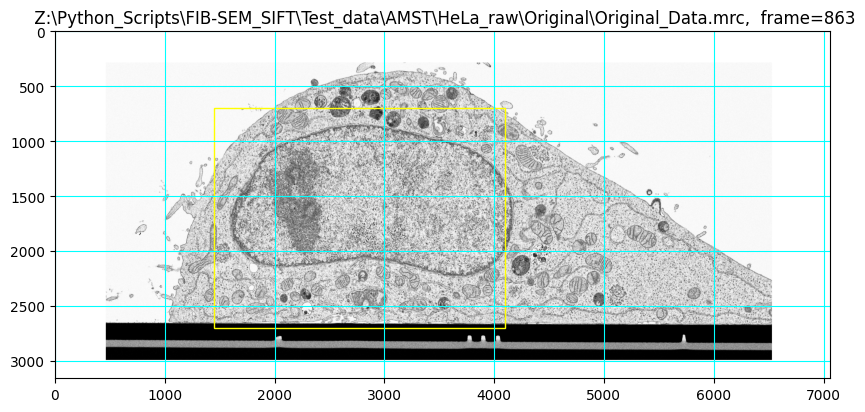

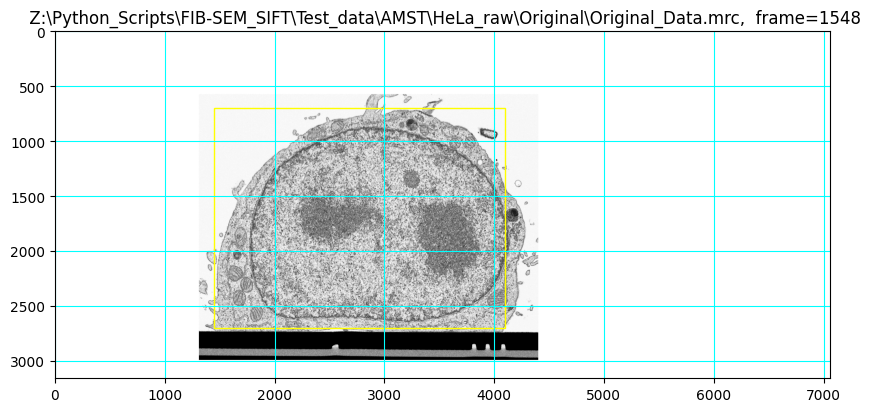

In [21]:
orig_mrc_stack = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw/Original/Original_Data.mrc'
evaluation_box = [700, 2000, 1450, 2650]
show_eval_box_mrc_stack(orig_mrc_stack, evaluation_box = evaluation_box)

2025/09/05  14:53:09  DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:8787/status to monitor DASK progress
2025/09/05  14:53:09   Will use fixed evaluation box:  [700, 2000, 1450, 2650]
mrc_mode=0  , dt_mrc= <class 'numpy.uint8'>
2025/09/05  14:53:09   Will analyze regstrations in 1726 frames
Will save the data into Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw/Original/Original_Data_withEB1_RegistrationQuality.xlsx
2025/09/05  14:53:09   Using DASK distributed
2025/09/05  14:58:35   Saving the Registration Quality Statistics into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw/Original/Original_Data_withEB1_RegistrationQuality.xlsx
CPU times: total: 29.2 s
Wall time: 5min 32s


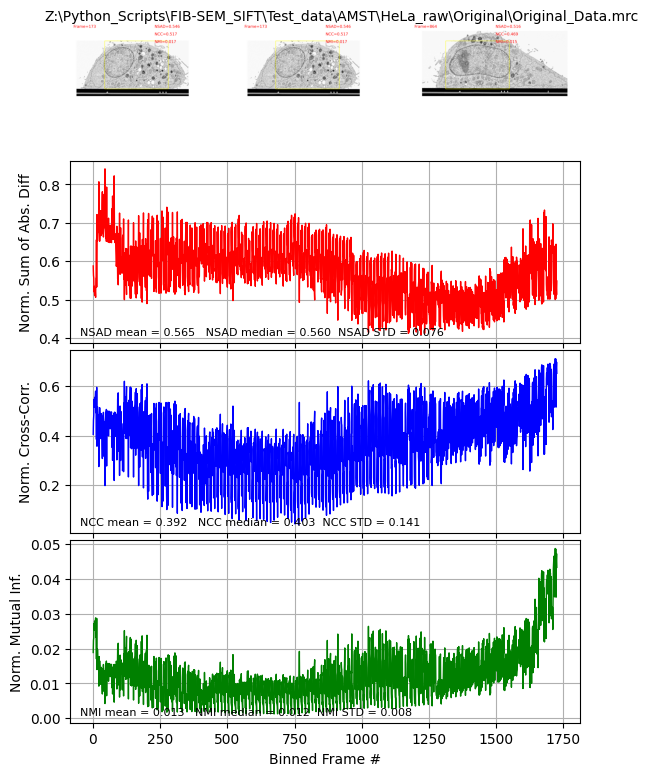

In [28]:
%%time
# alternative way - combine all tif files into a single mrc stack and then evaluate
evaluation_box = [700, 2000, 1450, 2650]
orig_mrc_stack = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw/Original/Original_Data.mrc'
save_filename  = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw/Original/Original_Data_withEB1.mrc'
with Client() as client:
    reg_summary_raw1, reg_summary_raw_xlsx1 = analyze_mrc_stack_registration(orig_mrc_stack,
                                                                         DASK_client = client,
                                                                        invert_data=False,
                                                                       evaluation_box = evaluation_box,
                                                                      save_filename=save_filename)
generate_report_from_xls_registration_summary(reg_summary_raw_xlsx1, sample_frames_layout = 'horizontal')

In [29]:
data_dir_AMST = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_amst_aligned'
fls_AMST = sorted(glob.glob(os.path.join(data_dir_AMST,'*.tif')))
test_dataset = FIBSEM_dataset(fls_AMST, **SIFT_kwargs)
test_dataset.data_dir = data_dir_AMST
test_dataset.fnm_reg = 'AMST_Data_orig.mrc'

2025/09/05  14:58:41   Registered data will be saved into:  Registered_I16_ShiftTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05.mrc
Total Number of frames:  1727


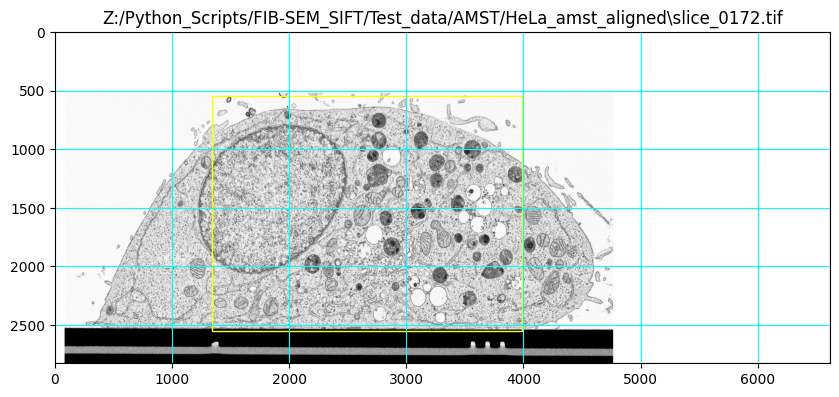

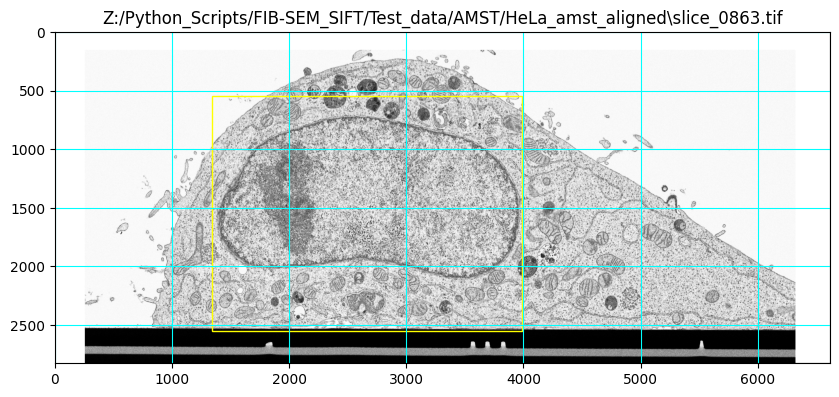

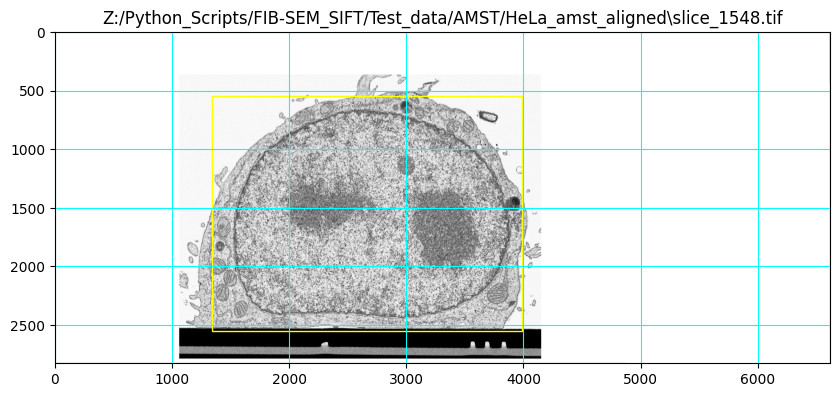

In [30]:
evaluation_box = [280, 2000, 1340, 2650]
test_dataset.show_eval_box(evaluation_box=evaluation_box,
                           perform_transformation=False,
                           flipY=True, invert_data=True)

2025/09/05  14:58:54   Registered data will be saved into:  Registered_I16_ShiftTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05.mrc
Total Number of frames:  1727
2025/09/05  14:58:54   DASK client does not exist. Will perform local computations
Evaluating the parameters of FIBSEM data set (data Min/Max, Working Distance, Milling Y Voltage, FOV center positions, Scan Rate, EHT)
Original data is 8-bit, no need to find Min and Max for 8-bit conversion
2025/09/05  14:58:54   Saving the FIBSEM dataset statistics (Min/Max, Mill Rate, FOV Shifts into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_amst_aligned\FIBSEM_Data.xlsx
No milling rate data is available, isotropic voxel size is set to 8.00 nm
2025/09/05  14:58:57  DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:8787/status to monitor DASK progress
Transforming and Saving Intermediate Registered Frames


Setting up parameter sets:   0%|          | 0/1727 [00:00<?, ?it/s]

2025/09/05  14:59:01   Transform and Save Chunks of Frames: Starting DASK jobs


C:\Users\labadmin\anaconda3\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 38.52 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2025/09/05  15:02:29   Finished DASK jobs
Analyzing Registration Quality
2025/09/05  15:02:30   Analyzing Frame Registration: Starting DASK jobs
2025/09/05  15:17:11   Finished DASK jobs
2025/09/05  15:17:19   Saving the Registration Quality Statistics into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_amst_aligned\AMST_Data_orig_RegistrationQuality.xlsx
Registered data set is NOT saved into a file


Removing Intermediate Registered Frame Files:   0%|          | 0/1727 [00:00<?, ?it/s]

CPU times: total: 3min 19s
Wall time: 19min 22s


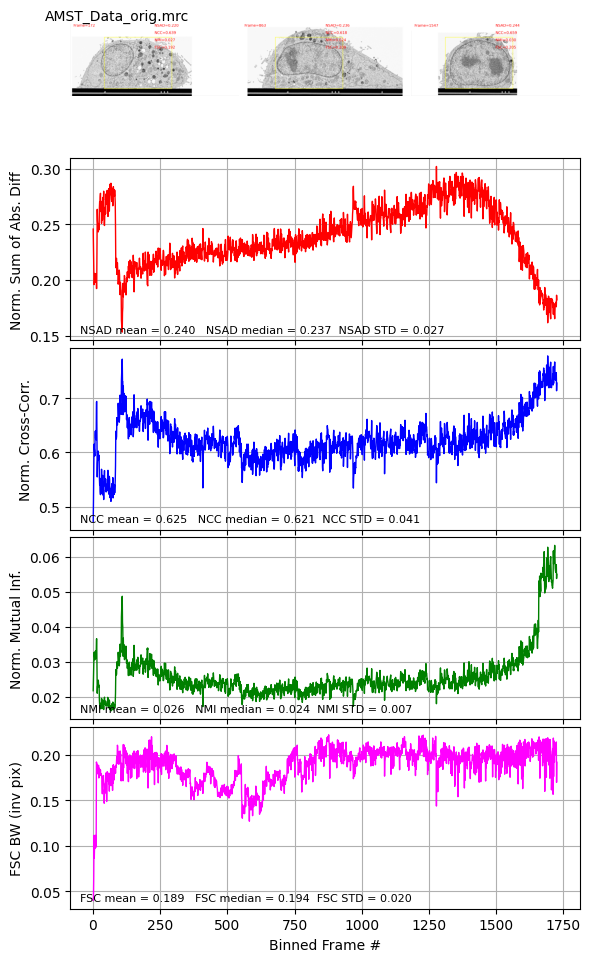

In [31]:
%%time
data_dir_AMST = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_amst_aligned'
fls_AMST = sorted(glob.glob(os.path.join(data_dir_AMST,'*.tif')))
test_dataset = FIBSEM_dataset(fls_AMST, **SIFT_kwargs)
test_dataset.data_dir = data_dir_AMST
test_dataset.fnm_reg = 'AMST_Data_orig.mrc'
FIBSEM_Data_AMST =  test_dataset.evaluate_FIBSEM_statistics(DASK_client = client)

evaluation_box = [280, 2000, 1340, 2650]       # optional evaluation box for defining the area over which the registration quality
                                                # is evaluated. It can be checked in the step above. The use 
                                                # of the method below would be:

with Client() as client:
    AMST_reg_summary, AMST_reg_summary_xlsx = test_dataset.transform_and_save(DASK_client = client,
                                                                          invert_data=True,
                                                                          flipY=True,
                                                                          perform_transformation=False,
                                                                          save_transformed_dataset = False,
                                                                          save_registration_summary = True,
                                                                          evaluation_box = evaluation_box)
generate_report_from_xls_registration_summary(AMST_reg_summary_xlsx, sample_frames_layout = 'horizontal')

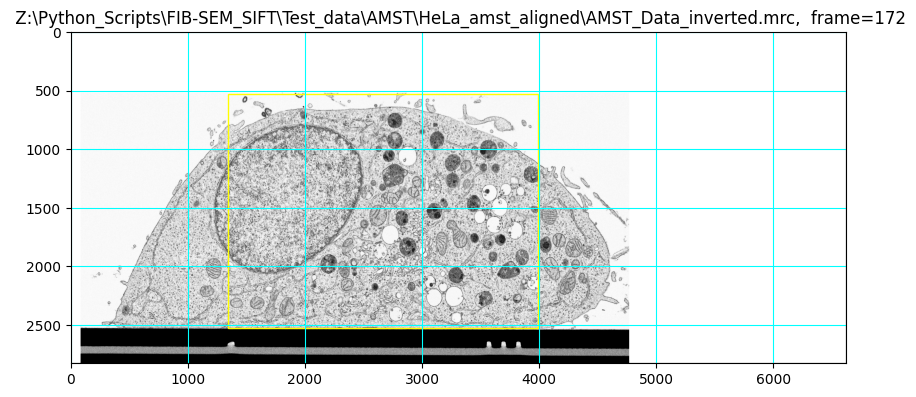

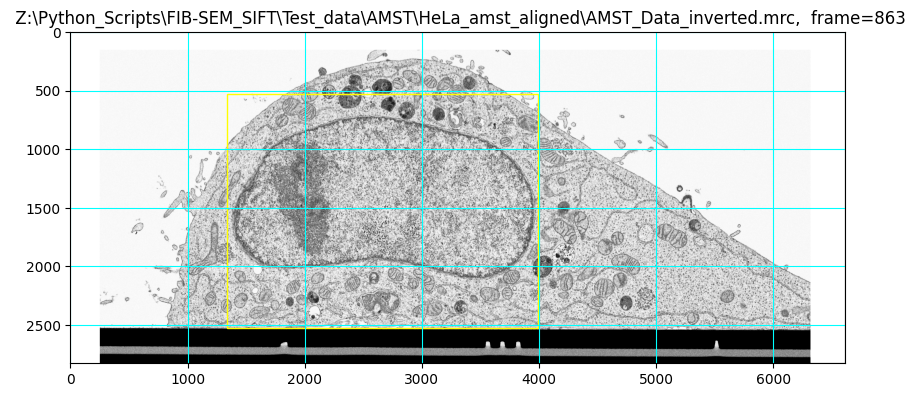

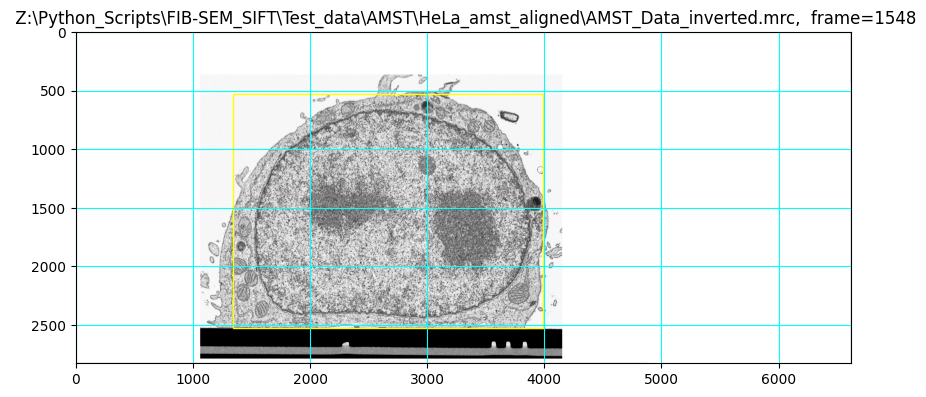

In [32]:
# alternative way - combine all tif files into a single mrc stack and then evaluate
AMST_reg_stack = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_amst_aligned/AMST_Data_inverted.mrc'
evaluation_box = [530, 2000, 1340, 2650]
show_eval_box_mrc_stack(AMST_reg_stack, evaluation_box=evaluation_box)

2025/09/05  15:18:30  DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:8787/status to monitor DASK progress
2025/09/05  15:18:30   Will use fixed evaluation box:  [530, 2000, 1340, 2650]
mrc_mode=0  , dt_mrc= <class 'numpy.uint8'>
2025/09/05  15:18:30   Will analyze regstrations in 1726 frames
Will save the data into Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_amst_aligned/AMST_Data_inverted_withEB1_RegistrationQuality.xlsx
2025/09/05  15:18:30   Using DASK distributed
2025/09/05  15:23:22   Saving the Registration Quality Statistics into the file:  Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_amst_aligned/AMST_Data_inverted_withEB1_RegistrationQuality.xlsx
CPU times: total: 38 s
Wall time: 4min 59s


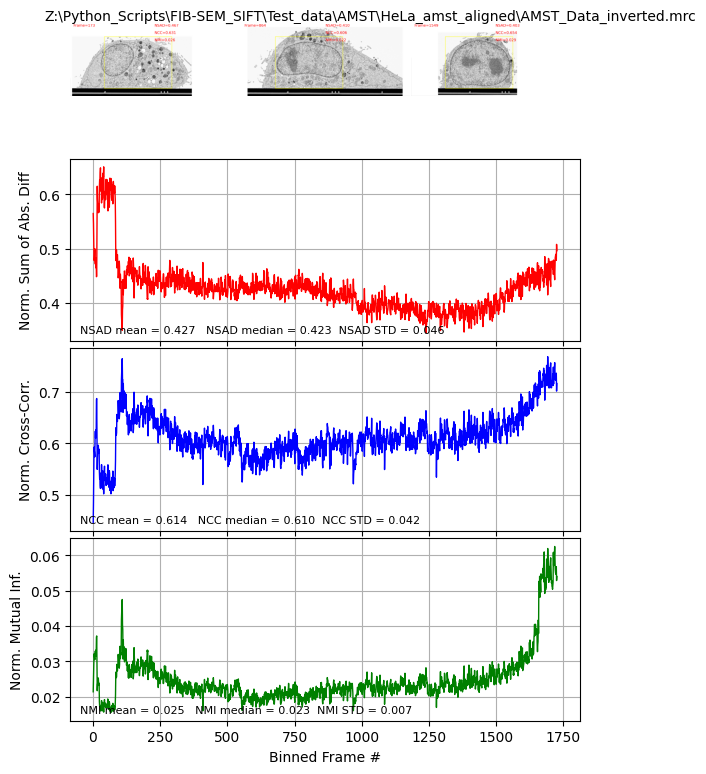

In [33]:
%%time
# alternative way - combine all tif files into a single mrc stack and then evaluate
AMST_reg_stack = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_amst_aligned/AMST_Data_inverted.mrc'
save_filename  = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_amst_aligned/AMST_Data_inverted_withEB1.mrc'
evaluation_box = [530, 2000, 1340, 2650]

with Client() as client:
    AMST_reg_summary1, AMST_reg_summary_xlsx1 = analyze_mrc_stack_registration(AMST_reg_stack,
                                                                           DASK_client = client,
                                                                        invert_data=False,
                                                                       evaluation_box = evaluation_box,
                                                                        save_filename=save_filename)
generate_report_from_xls_registration_summary(AMST_reg_summary_xlsx1, sample_frames_layout = 'horizontal')

# Build a Summary 

generating the registration quality summary plots:   0%|          | 0/7 [00:00<?, ?it/s]

saving the data into xlsx file:   0%|          | 0/7 [00:00<?, ?it/s]

'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST\\HeLa_raw\\Regstration_Summary.xlsx'

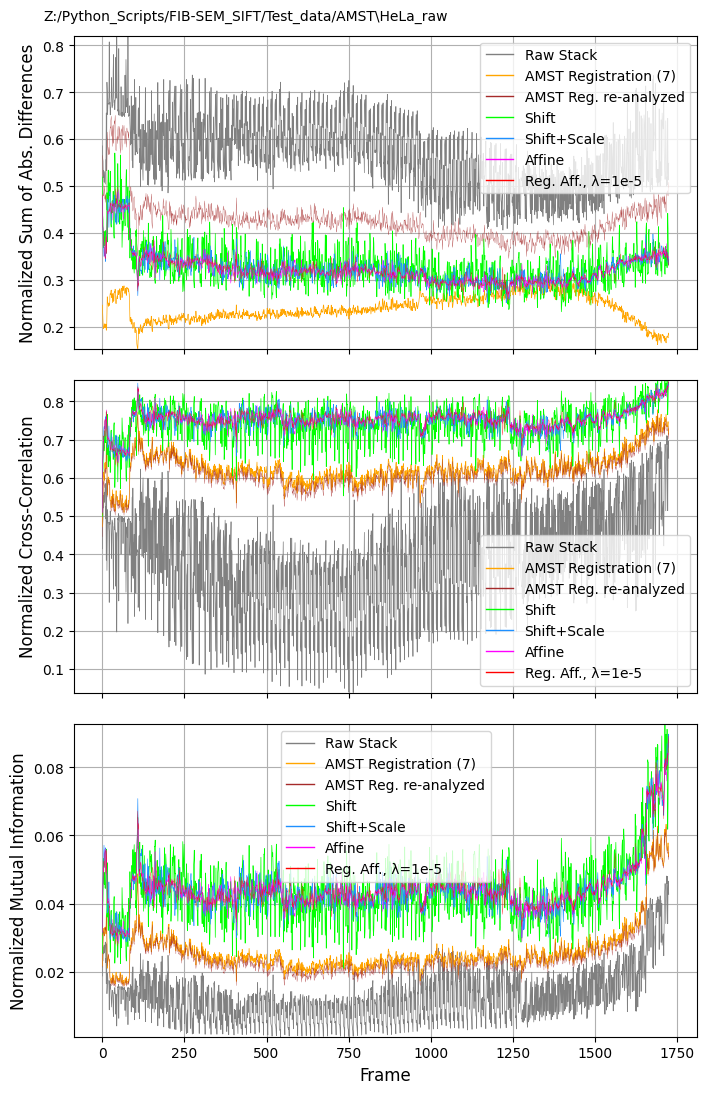

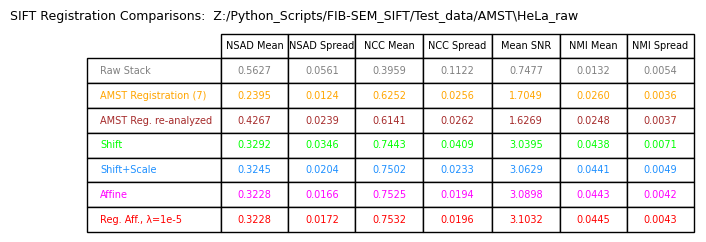

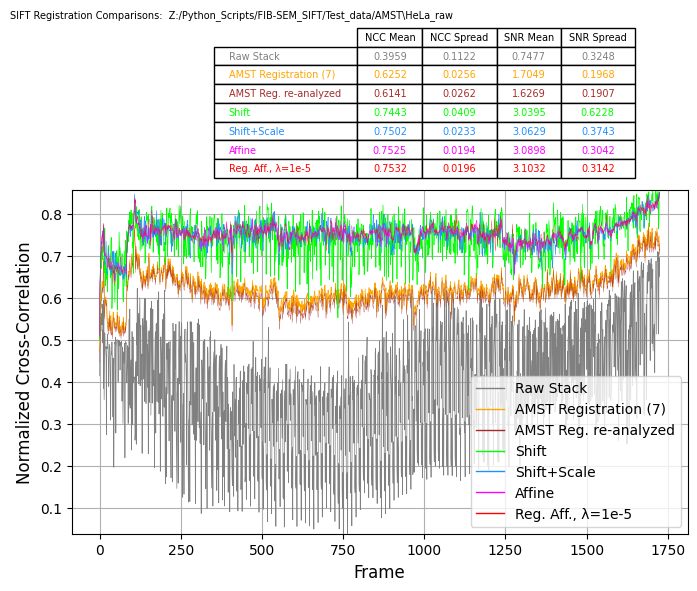

In [34]:
data_dir = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST'

reg_quality_files = ['HeLa_raw/raw_data_orig_RegistrationQuality.xlsx',
                     'HeLa_amst_aligned/AMST_Data_orig_RegistrationQuality.xlsx',
                     'HeLa_amst_aligned/AMST_Data_inverted_withEB1_RegistrationQuality.xlsx',
                     'HeLa_raw/Registered_Shift_RegistrationQuality.xlsx',
                     'HeLa_raw/Registered_ScaleShift_RegistrationQuality.xlsx',
                     'HeLa_raw/Registered_Affine_RegistrationQuality.xlsx',
                     'HeLa_raw/Registered_RegAffine_RegistrationQuality.xlsx']

colors = ['grey', 'orange', 'brown', 'lime', 'dodgerblue', 'magenta', 'red']
linewidths = [0.5, 0.5, 0.2, 0.5, 0.4, 0.3, 0.2]

reg_files = [os.path.join(data_dir, rf) for rf in reg_quality_files]

pfs = ['Raw Stack',
       'AMST Registration (7)',
       'AMST Reg. re-analyzed',
       'Shift',
       'Shift+Scale',
       'Affine',
       'Reg. Aff., λ=1e-5']

plot_registrtion_quality_xlsx(reg_files, pfs, colors=colors, linewidths=linewidths)